In [1]:
%matplotlib notebook
import format_local_Allen_data as flad
from  importlib import reload

import argparse
import io
import json
import os
import glob
import re
import zipfile,time
from typing import Mapping, Tuple, Union

import numpy as np
import requests
from skimage.io import imread
from slicedimage import ImageFormat

from starfish import Codebook
from starfish.experiment.builder import FetchedTile, TileFetcher
from starfish.experiment.builder import write_experiment_json
from starfish.types import Coordinates, Features, Axes, Number
from starfish.util.argparse import FsExistsType



import matplotlib.pyplot as plt
import numpy as np
import os,json

from starfish import data, FieldOfView
from starfish.types import Axes
from starfish import Experiment
from importlib import reload

from starfish.spots import SpotFinder
from starfish.image import Filter
import starfish.plot


import starfish.display


SHAPE = 2048, 2048
PIXEL_SIZE = 1e-7
Z_SPACING = 3e-7
TC_STRING = "TileConfig_405.txt"
CH_STRINGS = ["Bandpass405", "Bandpass488", "Bandpass561", "Bandpass640"]


reload(flad)

<module 'format_local_Allen_data' from '/home/brianl/projects/starfish/data_formatting_examples/format_local_Allen_data.py'>

In [107]:
experiment = Experiment.from_json("/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/Allen_Mouse_Panel_1/experiment.json")
#experiment = Experiment.from_json("/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_test_01/experiment.json")
#experiment = Experiment.from_json("/home/brianl/Desktop/temp/CZI_test_01/experiment.json")

In [108]:
experiment

<starfish.Experiment (FOVs=77)>
{
fov_000: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (c: 3, z: 34, r: 9, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (c: 1, z: 34, r: 9, x: 1536, y: 1024)>
fov_001: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (c: 3, z: 34, r: 9, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (c: 1, z: 34, r: 9, x: 1536, y: 1024)>
fov_002: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (c: 3, z: 34, r: 9, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (c: 1, z: 34, r: 9, x: 1536, y: 1024)>
fov_003: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (c: 3, z: 34, r: 9, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (c: 1, z: 34, r: 9, x: 1536, y: 1024)>
  ...,
}

In [109]:
# create the runnables for the pipeline, using in_place = False for the 
# first pipeline so the original data can still be looked at. This should be ok on a workstation
# since it should be reset for each fov

kwargs = dict(
    spot_diameter=5, # must be odd integer
    min_mass=0.02,
    max_size=2,  # this is max _radius_
    separation=7,
    noise_size=0.65,  # this is not used because preprocess is False
    preprocess=False,
    percentile=10,  # this is irrelevant when min_mass, spot_diameter, and max_size are set properly
    verbose=True,
    is_volume=True,
)
tlmpf = SpotFinder.TrackpyLocalMaxPeakFinder(**kwargs)
bandpass = Filter.Bandpass(lshort=.5, llong=7, threshold=0.0)
sigma=(1, 0, 0)  # filter only in z, do nothing in x, y
glp = Filter.GaussianLowPass(sigma=sigma, is_volume=True)
clip1 = Filter.Clip(p_min=50, p_max=100)
clip2 = Filter.Clip(p_min=99, p_max=100, is_volume=True)

def allen_pipeline(fov, codebook):
    primary_image = fov[FieldOfView.PRIMARY_IMAGES]
    new_image = clip1.run(primary_image, verbose=True, in_place=False, n_processes = 7)
    bandpass.run(new_image, verbose=True, in_place=True, n_processes = 7)
    glp.run(new_image, in_place=True, verbose=True, n_processes = 7)
    clip2.run(new_image, verbose=True, in_place=True, n_processes = 7)
    spot_attributes = tlmpf.run(new_image)
    decoded = codebook.decode_per_round_max(spot_attributes)
    return decoded[decoded["total_intensity"]>.025]


# process all the fields of view, not just one
def process_experiment_allen(experiment: Experiment):
    decoded_intensities = []
    for i, (name_, fov) in enumerate(experiment.items()):
        try:
            decoded = allen_pipeline(fov, experiment.codebook)
            decoded_intensities.append({"name":name_,"decoded": decoded})
        except:
            print("pipeline failed for fov "+name_)
            decoded_intensities.append({"name":name_,"decoded": None})
    return decoded_intensities



In [112]:
# "pipeline"   currently very slow, but probably mostly io limited
print(time.asctime())
decoded_intensities = []
top_dir = "/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_test_output/"
for i, (name_, fov) in enumerate(experiment.items()):
    decoded = allen_pipeline(fov, experiment.codebook)
    decoded_intensities.append({"name":name_,"decoded": decoded})
    print("finished tile "+name_+" at "+str(time.asctime()))
    decoded.save(top_dir+ name_+".ncdf")

Thu Feb 14 17:18:27 2019



 34%|███▎      | 309/918 [01:03<01:35,  6.38it/s]


 67%|██████▋   | 617/918 [01:54<00:50,  6.01it/s]


100%|██████████| 918/918 [02:44<00:00,  5.77it/s]
0it [00:00, ?it/s]
1it [00:00,  4.30it/s]
147it [00:00,  6.13it/s]
182it [00:01,  8.25it/s]
208it [00:01, 11.20it/s]
228it [00:01, 14.68it/s]
244it [00:02, 19.88it/s]
259it [00:02, 24.44it/s]
271it [00:02, 31.40it/s]
282it [00:02, 34.26it/s]
291it [00:02, 38.14it/s]
300it [00:03, 43.42it/s]
309it [00:03, 49.07it/s]
318it [00:03, 50.53it/s]


327it [00:03, 55.47it/s]
336it [00:03, 58.84it/s]
345it [00:03, 60.78it/s]
355it [00:03, 68.88it/s]
363it [00:04, 62.75it/s]
372it [00:04, 64.64it/s]
381it [00:04, 65.23it/s]
390it [00:04, 66.72it/s]
399it [00:04, 70.71it/s]
408it [00:04, 69.70it/s]
417it [00:04, 67.59it/s]
426it [00:04, 68.31it/s]
435it [00:05, 64.72it/s]
444it [00:05, 70.64it/s]
453it [00:05, 68.02it/s]
462it [00:05, 62.59it/s]
471it [00:05, 62.45it/s]
480it [00:05, 66.04it/s]
489it [00:05, 64.89it/s]
498it [00:06, 63.62it/s]
507it [00:06, 59.24it/s]
516it [00:06, 45.58it/s]
525it [00:06, 46.16it/s]
534it [00:06, 51.76it/s]
543it [00:06, 54.28it/s]
552it [00:07, 57.07it/s]
561it [00:07, 59.86it/s]
570it [00:07, 60.79it/s]
579it [00:07, 60.20it/s]
588it [00:07, 62.40it/s]
597it [00:07, 60.89it/s]
606it [00:07, 62.35it/s]
615it [00:08, 61.28it/s]
624it [00:08, 66.61it/s]
633it [00:08, 63.18it/s]
642it [00:08, 67.27it/s]
651it [00:08, 65.22it/s]
660it [00:08, 64.39it/s]
669it [00:08, 64.24it/s]
678it [00:09, 64.53it/s]


finished tile fov_000 at Thu Feb 14 17:25:55 2019



 34%|███▎      | 309/918 [01:01<01:42,  5.96it/s]


 67%|██████▋   | 617/918 [01:51<00:46,  6.50it/s]


100%|██████████| 918/918 [02:41<00:00,  6.26it/s]
0it [00:00, ?it/s]
1it [00:00,  6.62it/s]
147it [00:00,  9.43it/s]
187it [00:00, 12.89it/s]
218it [00:01, 17.43it/s]
243it [00:01, 22.65it/s]
263it [00:01, 29.63it/s]
280it [00:01, 36.50it/s]
294it [00:01, 42.33it/s]
306it [00:02, 52.19it/s]
318it [00:02, 54.00it/s]
328it [00:02, 61.32it/s]
338it [00:02, 68.52it/s]
354it [00:02, 71.81it/s]


364it [00:02, 77.36it/s]
381it [00:03, 79.84it/s]
391it [00:03, 81.66it/s]
400it [00:03, 81.60it/s]
417it [00:03, 83.56it/s]
435it [00:03, 87.40it/s]
445it [00:03, 86.50it/s]
454it [00:03, 84.64it/s]
471it [00:04, 79.52it/s]
480it [00:04, 76.00it/s]
489it [00:04, 43.80it/s]
507it [00:04, 51.76it/s]
516it [00:04, 57.86it/s]
525it [00:05, 62.53it/s]
543it [00:05, 69.52it/s]
552it [00:05, 68.63it/s]
561it [00:05, 72.15it/s]
579it [00:05, 77.48it/s]
588it [00:05, 77.95it/s]
606it [00:05, 82.50it/s]
615it [00:06, 82.61it/s]
633it [00:06, 81.71it/s]
642it [00:06, 83.38it/s]
651it [00:06, 85.16it/s]
669it [00:06, 83.16it/s]
678it [00:06, 84.22it/s]
687it [00:06, 84.92it/s]
705it [00:07, 87.82it/s]
714it [00:07, 85.59it/s]
723it [00:07, 85.70it/s]
732it [00:07, 85.35it/s]
750it [00:07, 86.01it/s]
759it [00:07, 81.46it/s]
768it [00:07, 78.95it/s]
777it [00:08, 79.06it/s]
786it [00:08, 74.16it/s]
795it [00:08, 76.23it/s]
804it [00:08, 78.46it/s]
813it [00:08, 71.28it/s]
822it [00:08, 74.11it/s]


finished tile fov_001 at Thu Feb 14 17:38:47 2019



 34%|███▎      | 309/918 [00:51<01:28,  6.91it/s]


 67%|██████▋   | 617/918 [01:40<00:52,  5.74it/s]


100%|██████████| 918/918 [02:29<00:00,  6.28it/s]
0it [00:00, ?it/s]
1it [00:00,  6.59it/s]
147it [00:00,  9.40it/s]
190it [00:00, 12.88it/s]
223it [00:01, 17.25it/s]
249it [00:01, 22.66it/s]
270it [00:01, 29.54it/s]
288it [00:01, 36.84it/s]
303it [00:02, 43.64it/s]
316it [00:02, 54.46it/s]
329it [00:02, 58.79it/s]
345it [00:02, 65.00it/s]
356it [00:02, 72.40it/s]
372it [00:02, 77.91it/s]


382it [00:02, 82.14it/s]
392it [00:02, 85.80it/s]
408it [00:03, 87.56it/s]
426it [00:03, 91.75it/s]
444it [00:03, 92.88it/s]
454it [00:03, 90.89it/s]
464it [00:03, 91.51it/s]
474it [00:03, 88.56it/s]
484it [00:03, 90.89it/s]
494it [00:04, 87.53it/s]
503it [00:04, 77.24it/s]
512it [00:04, 75.11it/s]
525it [00:04, 71.03it/s]
543it [00:04, 76.56it/s]
552it [00:04, 71.17it/s]
561it [00:05, 75.20it/s]
576it [00:05, 88.43it/s]
586it [00:05, 89.74it/s]
597it [00:05, 77.99it/s]
606it [00:05, 78.99it/s]
615it [00:05, 78.70it/s]
633it [00:05, 81.33it/s]
651it [00:06, 85.77it/s]
660it [00:06, 85.43it/s]
669it [00:06, 86.14it/s]
683it [00:06, 97.37it/s]
694it [00:06, 100.41it/s]
705it [00:06, 83.45it/s] 
723it [00:06, 86.90it/s]
733it [00:06, 89.82it/s]
750it [00:07, 90.53it/s]
760it [00:07, 88.07it/s]
770it [00:07, 84.50it/s]
779it [00:07, 84.46it/s]
788it [00:07, 82.44it/s]
797it [00:07, 82.33it/s]
806it [00:07, 73.98it/s]
814it [00:07, 74.94it/s]
822it [00:08, 73.59it/s]
831it [00:08, 73.24it/s

finished tile fov_002 at Thu Feb 14 17:49:38 2019



 34%|███▎      | 309/918 [00:59<01:37,  6.22it/s]


 67%|██████▋   | 617/918 [01:48<00:45,  6.67it/s]


100%|██████████| 918/918 [02:40<00:00,  6.38it/s]
0it [00:00, ?it/s]
1it [00:00,  6.12it/s]
147it [00:00,  8.73it/s]
188it [00:00, 12.02it/s]
220it [00:01, 16.19it/s]
245it [00:01, 22.10it/s]
267it [00:01, 28.27it/s]
285it [00:01, 36.37it/s]
301it [00:01, 43.64it/s]
318it [00:02, 53.77it/s]
331it [00:02, 64.35it/s]
345it [00:02, 71.03it/s]
363it [00:02, 79.18it/s]
375it [00:02, 87.98it/s]


390it [00:02, 89.64it/s]
408it [00:02, 96.76it/s]
426it [00:02, 102.84it/s]
444it [00:03, 105.21it/s]
462it [00:03, 97.97it/s] 
473it [00:03, 94.72it/s]
483it [00:03, 94.49it/s]
493it [00:03, 93.17it/s]
503it [00:03, 91.87it/s]
513it [00:03, 86.66it/s]
522it [00:04, 86.55it/s]
531it [00:04, 85.44it/s]
540it [00:04, 86.63it/s]
552it [00:04, 75.24it/s]
561it [00:04, 78.41it/s]
579it [00:04, 85.59it/s]
588it [00:04, 86.50it/s]
606it [00:05, 88.29it/s]
624it [00:05, 93.05it/s]
642it [00:05, 95.76it/s]
660it [00:05, 98.26it/s]
678it [00:05, 95.33it/s]
696it [00:05, 99.32it/s]
714it [00:06, 101.13it/s]
732it [00:06, 100.15it/s]
743it [00:06, 99.73it/s] 
759it [00:06, 95.33it/s]
769it [00:06, 88.93it/s]
779it [00:06, 83.86it/s]
788it [00:06, 85.26it/s]
797it [00:07, 82.47it/s]
806it [00:07, 37.23it/s]
813it [00:07, 39.68it/s]
822it [00:07, 46.32it/s]
831it [00:07, 53.41it/s]
840it [00:08, 60.41it/s]
849it [00:08, 65.63it/s]
858it [00:08, 67.04it/s]
867it [00:08, 68.26it/s]
876it [00:08, 72.88

finished tile fov_003 at Thu Feb 14 17:58:14 2019



 34%|███▎      | 309/918 [00:58<01:36,  6.33it/s]


 67%|██████▋   | 617/918 [01:51<00:48,  6.15it/s]


100%|██████████| 918/918 [02:44<00:00,  6.26it/s]
0it [00:00, ?it/s]
1it [00:00,  6.29it/s]
147it [00:00,  8.96it/s]
182it [00:00, 12.32it/s]
210it [00:01, 16.16it/s]
231it [00:01, 21.29it/s]
248it [00:01, 26.83it/s]
262it [00:01, 34.83it/s]
276it [00:01, 39.42it/s]
287it [00:02, 46.48it/s]
298it [00:02, 55.82it/s]
309it [00:02, 51.48it/s]
318it [00:02, 56.53it/s]
327it [00:02, 61.59it/s]


336it [00:02, 66.58it/s]
345it [00:02, 65.43it/s]
354it [00:03, 43.50it/s]
363it [00:03, 51.21it/s]
372it [00:03, 57.71it/s]
381it [00:03, 63.33it/s]
390it [00:03, 62.22it/s]
399it [00:03, 66.23it/s]
408it [00:04, 69.24it/s]
417it [00:04, 71.25it/s]
426it [00:04, 69.14it/s]
435it [00:04, 71.13it/s]
444it [00:04, 71.41it/s]
453it [00:04, 68.81it/s]
462it [00:04, 69.41it/s]
471it [00:04, 71.26it/s]
480it [00:05, 70.74it/s]
489it [00:05, 67.76it/s]
498it [00:05, 69.90it/s]
507it [00:05, 71.56it/s]
516it [00:05, 67.70it/s]
528it [00:05, 77.88it/s]
537it [00:05, 74.97it/s]
545it [00:05, 73.71it/s]
553it [00:06, 67.21it/s]
561it [00:06, 69.92it/s]
570it [00:06, 69.01it/s]
579it [00:06, 70.86it/s]
588it [00:06, 71.89it/s]
597it [00:06, 73.89it/s]
606it [00:06, 69.18it/s]
615it [00:06, 69.82it/s]
624it [00:07, 70.17it/s]
633it [00:07, 70.16it/s]
642it [00:07, 72.45it/s]
651it [00:07, 67.64it/s]
660it [00:07, 68.96it/s]
669it [00:07, 70.22it/s]
678it [00:07, 72.57it/s]
687it [00:07, 67.47it/s]


finished tile fov_004 at Thu Feb 14 18:06:06 2019



 34%|███▎      | 309/918 [01:05<01:28,  6.90it/s]


 67%|██████▋   | 617/918 [01:57<00:44,  6.72it/s]


100%|██████████| 918/918 [02:50<00:00,  5.52it/s]
0it [00:00, ?it/s]
1it [00:00,  5.83it/s]
146it [00:00,  8.32it/s]
189it [00:00, 11.46it/s]
222it [00:01, 15.38it/s]
248it [00:01, 20.41it/s]
269it [00:01, 26.70it/s]
286it [00:01, 33.45it/s]
301it [00:02, 39.92it/s]
314it [00:02, 50.30it/s]
327it [00:02, 53.76it/s]
338it [00:02, 62.38it/s]
353it [00:02, 65.42it/s]
371it [00:02, 71.25it/s]


381it [00:03, 76.54it/s]
398it [00:03, 79.38it/s]
408it [00:03, 84.21it/s]
425it [00:03, 83.20it/s]
443it [00:03, 86.28it/s]
453it [00:03, 88.11it/s]
463it [00:03, 84.02it/s]
472it [00:04, 78.50it/s]
481it [00:04, 78.73it/s]
490it [00:04, 81.59it/s]
499it [00:04, 74.27it/s]
507it [00:04, 74.78it/s]
515it [00:04, 67.89it/s]
524it [00:04, 69.26it/s]
533it [00:04, 72.21it/s]
542it [00:05, 73.71it/s]
551it [00:05, 74.78it/s]
560it [00:05, 72.44it/s]
569it [00:05, 76.60it/s]
587it [00:05, 80.19it/s]
596it [00:05, 75.77it/s]
605it [00:05, 77.80it/s]
614it [00:05, 80.08it/s]
623it [00:06, 79.30it/s]
632it [00:06, 78.07it/s]
641it [00:06, 77.76it/s]
650it [00:06, 79.03it/s]
659it [00:06, 79.87it/s]
677it [00:06, 83.27it/s]
686it [00:06, 75.97it/s]
695it [00:06, 75.12it/s]
713it [00:07, 77.90it/s]
722it [00:07, 78.52it/s]
740it [00:07, 81.59it/s]
749it [00:07, 79.48it/s]
758it [00:07, 76.96it/s]
767it [00:07, 78.37it/s]
776it [00:07, 75.88it/s]
785it [00:08, 74.32it/s]
794it [00:08, 73.20it/s]


finished tile fov_005 at Thu Feb 14 18:20:42 2019



 34%|███▎      | 309/918 [01:04<01:47,  5.66it/s]


 67%|██████▋   | 617/918 [01:57<00:50,  5.97it/s]


100%|██████████| 918/918 [02:46<00:00,  6.17it/s]
0it [00:00, ?it/s]
1it [00:00,  6.33it/s]
147it [00:00,  9.02it/s]
180it [00:00, 12.36it/s]
206it [00:01, 16.49it/s]
227it [00:01, 21.62it/s]
244it [00:01, 27.89it/s]
259it [00:01, 34.09it/s]
271it [00:01, 42.60it/s]
283it [00:02, 44.10it/s]
300it [00:02, 52.18it/s]
318it [00:02, 59.14it/s]
328it [00:02, 66.40it/s]
345it [00:02, 72.01it/s]


355it [00:02, 73.19it/s]
364it [00:02, 77.16it/s]
381it [00:03, 79.24it/s]
399it [00:03, 81.21it/s]
417it [00:03, 83.36it/s]
426it [00:03, 83.57it/s]
435it [00:03, 81.76it/s]
444it [00:03, 83.84it/s]
453it [00:04, 82.08it/s]
462it [00:04, 75.18it/s]
471it [00:04, 75.94it/s]
480it [00:04, 74.85it/s]
489it [00:04, 78.11it/s]
498it [00:04, 72.34it/s]
507it [00:04, 71.74it/s]
516it [00:04, 71.61it/s]
525it [00:05, 74.43it/s]
534it [00:05, 75.61it/s]
543it [00:05, 73.10it/s]
552it [00:05, 75.94it/s]
561it [00:05, 77.44it/s]
570it [00:05, 77.32it/s]
579it [00:05, 73.92it/s]
588it [00:05, 77.42it/s]
597it [00:05, 77.91it/s]
606it [00:06, 77.96it/s]
615it [00:06, 79.03it/s]
624it [00:06, 80.15it/s]
633it [00:06, 79.79it/s]
651it [00:06, 80.24it/s]
660it [00:06, 79.58it/s]
669it [00:06, 78.26it/s]
678it [00:06, 79.47it/s]
687it [00:07, 82.09it/s]
696it [00:07, 79.48it/s]
705it [00:07, 79.08it/s]
723it [00:07, 80.38it/s]
738it [00:07, 93.38it/s]
749it [00:07, 93.13it/s]
759it [00:07, 69.61it/s]


finished tile fov_006 at Thu Feb 14 18:35:05 2019



 34%|███▎      | 309/918 [00:53<01:41,  6.00it/s]


 67%|██████▋   | 617/918 [01:45<00:49,  6.05it/s]


100%|██████████| 918/918 [02:35<00:00,  6.23it/s]
0it [00:00, ?it/s]
1it [00:00,  6.28it/s]
148it [00:00,  8.95it/s]
188it [00:00, 12.28it/s]
219it [00:01, 16.69it/s]
244it [00:01, 21.72it/s]
264it [00:01, 28.33it/s]
281it [00:01, 35.27it/s]
295it [00:02, 39.97it/s]
307it [00:02, 49.22it/s]
319it [00:02, 50.25it/s]
337it [00:02, 56.36it/s]
355it [00:02, 63.34it/s]
373it [00:02, 70.63it/s]


383it [00:03, 75.27it/s]
393it [00:03, 78.12it/s]
409it [00:03, 78.61it/s]
427it [00:03, 85.72it/s]
437it [00:03, 85.55it/s]
454it [00:03, 85.30it/s]
463it [00:04, 78.80it/s]
472it [00:04, 79.07it/s]
481it [00:04, 79.78it/s]
490it [00:04, 81.53it/s]
499it [00:04, 76.11it/s]
508it [00:04, 74.50it/s]
517it [00:04, 76.63it/s]
526it [00:04, 78.34it/s]
544it [00:05, 78.49it/s]
553it [00:05, 77.42it/s]
571it [00:05, 81.17it/s]
580it [00:05, 78.17it/s]
589it [00:05, 76.78it/s]
598it [00:05, 77.75it/s]
607it [00:05, 78.02it/s]
625it [00:06, 80.89it/s]
634it [00:06, 79.54it/s]
643it [00:06, 79.49it/s]
661it [00:06, 82.19it/s]
670it [00:06, 78.60it/s]
679it [00:06, 76.86it/s]
697it [00:06, 78.08it/s]
706it [00:07, 79.70it/s]
715it [00:07, 82.15it/s]
724it [00:07, 80.69it/s]
733it [00:07, 80.68it/s]
751it [00:07, 85.22it/s]
760it [00:07, 77.65it/s]
769it [00:07, 79.02it/s]
778it [00:07, 80.83it/s]
787it [00:08, 78.19it/s]
796it [00:08, 78.68it/s]
805it [00:08, 74.20it/s]
814it [00:08, 76.77it/s]


finished tile fov_007 at Thu Feb 14 18:50:05 2019



 34%|███▎      | 309/918 [00:59<01:31,  6.67it/s]


 67%|██████▋   | 617/918 [01:50<00:44,  6.84it/s]


100%|██████████| 918/918 [02:41<00:00,  6.83it/s]
0it [00:00, ?it/s]
1it [00:00,  6.15it/s]
146it [00:00,  8.76it/s]
188it [00:00, 12.05it/s]
220it [00:01, 16.13it/s]
245it [00:01, 21.25it/s]
265it [00:01, 27.73it/s]
282it [00:01, 34.50it/s]
297it [00:01, 44.60it/s]
312it [00:02, 50.85it/s]
326it [00:02, 56.77it/s]
337it [00:02, 66.11it/s]
353it [00:02, 69.49it/s]
371it [00:02, 77.07it/s]


382it [00:02, 82.88it/s]
393it [00:03, 89.08it/s]
407it [00:03, 87.23it/s]
417it [00:03, 89.48it/s]
427it [00:03, 91.39it/s]
443it [00:03, 88.82it/s]
453it [00:03, 90.77it/s]
463it [00:03, 81.58it/s]
472it [00:03, 81.89it/s]
488it [00:04, 80.75it/s]
497it [00:04, 78.78it/s]
506it [00:04, 77.49it/s]
515it [00:04, 80.78it/s]
524it [00:04, 74.87it/s]
542it [00:04, 78.05it/s]
560it [00:05, 79.77it/s]
569it [00:05, 82.51it/s]
578it [00:05, 83.26it/s]
587it [00:05, 81.16it/s]
596it [00:05, 79.27it/s]
605it [00:05, 81.42it/s]
614it [00:05, 67.59it/s]
623it [00:05, 65.84it/s]
641it [00:06, 70.59it/s]
650it [00:06, 74.67it/s]
659it [00:06, 71.53it/s]
668it [00:06, 73.40it/s]
677it [00:06, 74.97it/s]
686it [00:06, 76.25it/s]
695it [00:06, 79.12it/s]
713it [00:07, 82.53it/s]
722it [00:07, 80.66it/s]
740it [00:07, 84.73it/s]
749it [00:07, 76.52it/s]
758it [00:07, 74.98it/s]
776it [00:07, 79.27it/s]
785it [00:07, 75.26it/s]
794it [00:08, 78.85it/s]
803it [00:08, 77.43it/s]
812it [00:08, 72.72it/s]


finished tile fov_008 at Thu Feb 14 19:03:23 2019



 34%|███▎      | 309/918 [01:01<01:25,  7.11it/s]


 67%|██████▋   | 617/918 [01:53<00:43,  6.95it/s]


100%|██████████| 918/918 [02:42<00:00,  6.81it/s]
0it [00:00, ?it/s]
1it [00:00,  6.02it/s]
148it [00:00,  8.59it/s]
187it [00:00, 11.75it/s]
217it [00:01, 15.93it/s]
241it [00:01, 20.86it/s]
260it [00:01, 27.07it/s]
276it [00:01, 33.16it/s]
292it [00:02, 39.88it/s]
304it [00:02, 49.56it/s]
316it [00:02, 58.95it/s]
328it [00:02, 57.34it/s]
338it [00:02, 62.19it/s]
347it [00:02, 65.87it/s]


356it [00:02, 67.20it/s]
365it [00:02, 69.86it/s]
373it [00:03, 66.54it/s]
391it [00:03, 69.05it/s]
400it [00:03, 71.22it/s]
409it [00:03, 72.96it/s]
418it [00:03, 73.43it/s]
427it [00:03, 76.50it/s]
436it [00:03, 76.96it/s]
445it [00:04, 77.28it/s]
454it [00:04, 69.17it/s]
463it [00:04, 67.73it/s]
472it [00:04, 65.15it/s]
481it [00:04, 70.14it/s]
490it [00:04, 71.01it/s]
499it [00:04, 70.44it/s]
508it [00:04, 75.01it/s]
517it [00:05, 69.59it/s]
526it [00:05, 73.20it/s]
535it [00:05, 76.05it/s]
544it [00:05, 78.42it/s]
553it [00:05, 75.61it/s]
562it [00:05, 73.58it/s]
571it [00:05, 76.87it/s]
589it [00:06, 76.43it/s]
598it [00:06, 78.73it/s]
616it [00:06, 77.59it/s]
625it [00:06, 78.06it/s]
634it [00:06, 78.47it/s]
643it [00:06, 79.50it/s]
652it [00:06, 77.31it/s]
670it [00:07, 80.30it/s]
679it [00:07, 80.85it/s]
688it [00:07, 74.96it/s]
697it [00:07, 75.19it/s]
715it [00:07, 78.54it/s]
724it [00:07, 75.57it/s]
742it [00:07, 78.94it/s]
751it [00:08, 81.87it/s]
760it [00:08, 74.10it/s]


finished tile fov_009 at Thu Feb 14 19:14:04 2019



 34%|███▎      | 309/918 [01:00<01:32,  6.60it/s]


 67%|██████▋   | 617/918 [01:55<00:50,  5.97it/s]


100%|██████████| 918/918 [02:47<00:00,  6.20it/s]
0it [00:00, ?it/s]
1it [00:00,  5.97it/s]
146it [00:00,  8.52it/s]
189it [00:00, 11.73it/s]
222it [00:01, 15.73it/s]
248it [00:01, 20.73it/s]
269it [00:01, 27.56it/s]
287it [00:01, 34.80it/s]
303it [00:02, 42.25it/s]
317it [00:02, 49.23it/s]
335it [00:02, 57.01it/s]
353it [00:02, 64.26it/s]
371it [00:02, 73.25it/s]
389it [00:02, 77.45it/s]


407it [00:03, 84.34it/s]
418it [00:03, 87.45it/s]
429it [00:03, 93.06it/s]
443it [00:03, 89.31it/s]
453it [00:03, 85.04it/s]
463it [00:03, 82.37it/s]
472it [00:03, 79.91it/s]
481it [00:04, 80.42it/s]
490it [00:04, 80.43it/s]
499it [00:04, 74.50it/s]
507it [00:04, 71.92it/s]
515it [00:04, 68.47it/s]
524it [00:04, 72.25it/s]
533it [00:04, 73.77it/s]
542it [00:04, 72.79it/s]
551it [00:04, 74.57it/s]
560it [00:05, 77.29it/s]
569it [00:05, 77.18it/s]
578it [00:05, 76.79it/s]
596it [00:05, 78.29it/s]
605it [00:05, 79.91it/s]
614it [00:05, 78.11it/s]
632it [00:05, 84.09it/s]
641it [00:06, 83.96it/s]
650it [00:06, 80.19it/s]
659it [00:06, 82.56it/s]
668it [00:06, 84.46it/s]
677it [00:06, 85.42it/s]
686it [00:06, 80.28it/s]
704it [00:06, 87.09it/s]
713it [00:06, 76.39it/s]
731it [00:07, 83.29it/s]
740it [00:07, 84.45it/s]
749it [00:07, 82.90it/s]
758it [00:07, 80.34it/s]
767it [00:07, 82.62it/s]
776it [00:07, 72.93it/s]
785it [00:07, 75.91it/s]
794it [00:07, 70.08it/s]
803it [00:08, 73.83it/s]


finished tile fov_010 at Thu Feb 14 19:22:18 2019



 34%|███▎      | 309/918 [00:55<01:32,  6.56it/s]


 67%|██████▋   | 617/918 [01:50<00:44,  6.71it/s]


100%|██████████| 918/918 [02:39<00:00,  6.09it/s]
0it [00:00, ?it/s]
1it [00:00,  5.67it/s]
147it [00:00,  8.08it/s]
178it [00:00, 11.11it/s]
202it [00:01, 14.84it/s]
221it [00:01, 19.74it/s]
237it [00:01, 25.24it/s]
251it [00:01, 33.40it/s]
265it [00:01, 39.28it/s]
277it [00:01, 48.60it/s]
289it [00:01, 59.09it/s]
301it [00:02, 62.37it/s]
313it [00:02, 72.86it/s]
324it [00:02, 78.89it/s]


336it [00:02, 76.49it/s]
346it [00:02, 77.59it/s]
363it [00:02, 80.94it/s]
373it [00:02, 83.76it/s]
383it [00:03, 84.79it/s]
399it [00:03, 87.74it/s]
409it [00:03, 90.36it/s]
426it [00:03, 86.66it/s]
444it [00:03, 91.59it/s]
454it [00:03, 80.70it/s]
463it [00:04, 78.06it/s]
472it [00:04, 79.72it/s]
481it [00:04, 77.98it/s]
489it [00:04, 68.88it/s]
498it [00:04, 72.74it/s]
507it [00:04, 72.70it/s]
516it [00:04, 70.21it/s]
525it [00:04, 73.56it/s]
534it [00:04, 73.48it/s]
543it [00:05, 69.80it/s]
561it [00:05, 72.12it/s]
579it [00:05, 75.25it/s]
588it [00:05, 73.26it/s]
605it [00:05, 88.18it/s]
616it [00:06, 71.94it/s]
633it [00:06, 76.06it/s]
642it [00:06, 77.46it/s]
660it [00:06, 82.24it/s]
669it [00:06, 76.30it/s]
678it [00:06, 79.33it/s]
687it [00:06, 78.77it/s]
696it [00:06, 81.05it/s]
705it [00:07, 80.61it/s]
714it [00:07, 80.60it/s]
723it [00:07, 79.68it/s]
732it [00:07, 81.48it/s]
741it [00:07, 80.66it/s]
750it [00:07, 81.18it/s]
759it [00:07, 73.79it/s]
768it [00:07, 71.96it/s]


finished tile fov_011 at Thu Feb 14 19:32:05 2019



 34%|███▎      | 309/918 [01:01<01:34,  6.48it/s]


 67%|██████▋   | 617/918 [01:51<00:46,  6.47it/s]


100%|██████████| 918/918 [02:40<00:00,  6.10it/s]
0it [00:00, ?it/s]
1it [00:00,  5.76it/s]
146it [00:00,  8.21it/s]
183it [00:00, 11.22it/s]
211it [00:01, 15.19it/s]
234it [00:01, 20.34it/s]
253it [00:01, 26.61it/s]
269it [00:01, 32.82it/s]
283it [00:01, 38.94it/s]
295it [00:02, 48.37it/s]
308it [00:02, 52.79it/s]
318it [00:02, 60.18it/s]
328it [00:02, 67.01it/s]
338it [00:02, 73.93it/s]


348it [00:02, 79.21it/s]
358it [00:02, 78.59it/s]
371it [00:02, 76.42it/s]
380it [00:03, 78.56it/s]
398it [00:03, 81.11it/s]
416it [00:03, 83.22it/s]
425it [00:03, 82.16it/s]
443it [00:03, 83.66it/s]
452it [00:03, 81.53it/s]
470it [00:04, 81.41it/s]
479it [00:04, 76.34it/s]
488it [00:04, 76.61it/s]
497it [00:04, 79.72it/s]
506it [00:04, 71.50it/s]
524it [00:04, 73.53it/s]
533it [00:05, 76.86it/s]
542it [00:05, 76.81it/s]
551it [00:05, 75.76it/s]
560it [00:05, 74.60it/s]
569it [00:05, 77.94it/s]
578it [00:05, 75.48it/s]
587it [00:05, 77.82it/s]
596it [00:05, 75.80it/s]
605it [00:05, 78.27it/s]
623it [00:06, 78.33it/s]
641it [00:06, 82.67it/s]
650it [00:06, 79.09it/s]
663it [00:06, 89.62it/s]
677it [00:06, 80.59it/s]
686it [00:06, 81.23it/s]
695it [00:07, 80.39it/s]
713it [00:07, 82.80it/s]
722it [00:07, 83.65it/s]
731it [00:07, 83.27it/s]
740it [00:07, 79.59it/s]
749it [00:07, 79.94it/s]
758it [00:07, 80.49it/s]
767it [00:07, 75.00it/s]
776it [00:08, 77.08it/s]
785it [00:08, 78.19it/s]


finished tile fov_012 at Thu Feb 14 19:45:49 2019



 34%|███▎      | 309/918 [00:57<01:34,  6.45it/s]


 67%|██████▋   | 617/918 [01:51<00:46,  6.46it/s]


100%|██████████| 918/918 [02:39<00:00,  6.08it/s]
0it [00:00, ?it/s]
1it [00:00,  6.44it/s]
147it [00:00,  9.18it/s]
188it [00:01, 11.86it/s]
218it [00:01, 16.06it/s]
242it [00:02, 21.02it/s]
261it [00:02, 27.63it/s]
278it [00:02, 34.67it/s]
292it [00:02, 41.85it/s]
305it [00:02, 52.49it/s]
318it [00:02, 55.68it/s]
329it [00:02, 65.18it/s]
345it [00:03, 68.68it/s]
363it [00:03, 76.04it/s]


381it [00:03, 85.64it/s]
392it [00:03, 85.95it/s]
408it [00:03, 90.53it/s]
426it [00:03, 94.93it/s]
444it [00:04, 95.53it/s]
455it [00:04, 95.07it/s]
465it [00:04, 89.84it/s]
475it [00:04, 88.85it/s]
485it [00:04, 89.85it/s]
495it [00:04, 84.74it/s]
504it [00:04, 82.25it/s]
513it [00:04, 82.18it/s]
525it [00:05, 71.95it/s]
534it [00:05, 69.76it/s]
552it [00:05, 74.18it/s]
561it [00:05, 73.36it/s]
579it [00:05, 77.84it/s]
588it [00:05, 78.37it/s]
606it [00:06, 81.06it/s]
615it [00:06, 80.35it/s]
633it [00:06, 82.51it/s]
642it [00:06, 84.13it/s]
651it [00:06, 85.10it/s]
660it [00:06, 77.79it/s]
678it [00:07, 83.57it/s]
687it [00:07, 84.74it/s]
696it [00:07, 81.86it/s]
714it [00:07, 86.40it/s]
723it [00:07, 85.77it/s]
741it [00:07, 87.06it/s]
759it [00:07, 85.47it/s]
768it [00:08, 80.97it/s]
777it [00:08, 79.60it/s]
786it [00:08, 72.16it/s]
795it [00:08, 75.97it/s]
804it [00:08, 75.45it/s]
813it [00:08, 78.35it/s]
822it [00:08, 73.65it/s]
831it [00:08, 76.59it/s]
840it [00:09, 78.83it/s]


finished tile fov_013 at Thu Feb 14 20:00:10 2019



 34%|███▎      | 309/918 [01:01<01:39,  6.14it/s]


 67%|██████▋   | 617/918 [01:51<00:48,  6.17it/s]


100%|██████████| 918/918 [02:39<00:00,  6.49it/s]
0it [00:00, ?it/s]
1it [00:00,  6.09it/s]
147it [00:00,  8.69it/s]
186it [00:00, 11.87it/s]
216it [00:01, 15.99it/s]
240it [00:01, 20.91it/s]
259it [00:01, 27.15it/s]
275it [00:01, 33.75it/s]
291it [00:02, 41.17it/s]
303it [00:02, 50.89it/s]
315it [00:02, 60.90it/s]
327it [00:02, 59.41it/s]
345it [00:02, 64.88it/s]
363it [00:02, 70.35it/s]


381it [00:03, 76.92it/s]
391it [00:03, 80.78it/s]
408it [00:03, 81.65it/s]
426it [00:03, 85.54it/s]
444it [00:03, 84.48it/s]
453it [00:03, 80.97it/s]
462it [00:04, 73.46it/s]
471it [00:04, 70.81it/s]
480it [00:04, 71.51it/s]
489it [00:04, 67.96it/s]
498it [00:04, 70.46it/s]
507it [00:04, 73.83it/s]
516it [00:04, 75.14it/s]
525it [00:04, 73.72it/s]
534it [00:05, 77.45it/s]
543it [00:05, 73.57it/s]
552it [00:05, 75.42it/s]
561it [00:05, 77.53it/s]
570it [00:05, 77.21it/s]
588it [00:05, 78.53it/s]
597it [00:05, 81.44it/s]
606it [00:05, 78.18it/s]
624it [00:06, 80.32it/s]
633it [00:06, 78.79it/s]
642it [00:06, 78.95it/s]
651it [00:06, 81.33it/s]
669it [00:06, 80.61it/s]
678it [00:06, 81.73it/s]
687it [00:06, 83.90it/s]
696it [00:07, 81.21it/s]
705it [00:07, 79.87it/s]
723it [00:07, 81.79it/s]
741it [00:07, 84.99it/s]
750it [00:07, 83.35it/s]
759it [00:07, 83.69it/s]
768it [00:07, 74.92it/s]
777it [00:08, 75.43it/s]
786it [00:08, 75.08it/s]
795it [00:08, 67.83it/s]
813it [00:08, 72.65it/s]


finished tile fov_014 at Thu Feb 14 20:13:32 2019



 34%|███▎      | 309/918 [01:06<01:31,  6.66it/s]


 67%|██████▋   | 617/918 [01:59<00:45,  6.61it/s]


100%|██████████| 918/918 [02:55<00:00,  5.94it/s]
0it [00:00, ?it/s]
1it [00:00,  5.27it/s]
148it [00:00,  7.52it/s]
186it [00:00, 10.34it/s]
216it [00:01, 14.03it/s]
239it [00:01, 18.52it/s]
258it [00:01, 24.33it/s]
274it [00:01, 30.68it/s]
288it [00:01, 39.07it/s]
301it [00:02, 45.44it/s]
312it [00:02, 54.52it/s]
323it [00:02, 63.51it/s]
337it [00:02, 63.86it/s]
347it [00:02, 71.37it/s]


357it [00:02, 76.62it/s]
373it [00:02, 79.35it/s]
383it [00:03, 82.13it/s]
393it [00:03, 76.48it/s]
409it [00:03, 81.58it/s]
418it [00:03, 82.69it/s]
427it [00:03, 81.71it/s]
445it [00:03, 85.10it/s]
454it [00:03, 81.21it/s]
463it [00:04, 80.45it/s]
472it [00:04, 76.13it/s]
481it [00:04, 79.08it/s]
490it [00:04, 75.73it/s]
499it [00:04, 75.19it/s]
508it [00:04, 75.57it/s]
526it [00:04, 80.03it/s]
535it [00:04, 75.26it/s]
544it [00:05, 76.10it/s]
553it [00:05, 78.27it/s]
571it [00:05, 80.49it/s]
580it [00:05, 83.00it/s]
589it [00:05, 82.12it/s]
598it [00:05, 76.70it/s]
616it [00:05, 80.88it/s]
625it [00:06, 75.62it/s]
634it [00:06, 79.25it/s]
643it [00:06, 81.24it/s]
652it [00:06, 80.99it/s]
661it [00:06, 79.07it/s]
679it [00:06, 78.85it/s]
688it [00:06, 80.73it/s]
697it [00:06, 81.39it/s]
715it [00:07, 83.23it/s]
724it [00:07, 79.97it/s]
733it [00:07, 82.67it/s]
742it [00:07, 83.76it/s]
751it [00:07, 83.75it/s]
760it [00:07, 76.54it/s]
769it [00:07, 78.96it/s]
778it [00:08, 73.24it/s]


finished tile fov_015 at Thu Feb 14 20:30:15 2019



 34%|███▎      | 309/918 [01:02<01:33,  6.48it/s]


 67%|██████▋   | 617/918 [01:54<00:46,  6.45it/s]


100%|██████████| 918/918 [02:43<00:00,  6.23it/s]
0it [00:00, ?it/s]
1it [00:00,  6.03it/s]
147it [00:00,  8.60it/s]
188it [00:00, 11.80it/s]
220it [00:01, 15.72it/s]
245it [00:01, 21.28it/s]
266it [00:01, 26.65it/s]
283it [00:01, 33.06it/s]
297it [00:02, 42.53it/s]
311it [00:02, 47.92it/s]
323it [00:02, 57.50it/s]
335it [00:02, 67.20it/s]
347it [00:02, 64.39it/s]
357it [00:02, 71.29it/s]


372it [00:02, 72.94it/s]
382it [00:03, 78.69it/s]
399it [00:03, 81.22it/s]
417it [00:03, 84.59it/s]
427it [00:03, 85.65it/s]
444it [00:03, 86.27it/s]
453it [00:03, 79.25it/s]
471it [00:04, 79.55it/s]
480it [00:04, 80.84it/s]
489it [00:04, 77.01it/s]
498it [00:04, 80.18it/s]
507it [00:04, 77.37it/s]
516it [00:04, 78.29it/s]
525it [00:04, 76.83it/s]
543it [00:05, 78.59it/s]
552it [00:05, 76.90it/s]
561it [00:05, 76.86it/s]
570it [00:05, 75.38it/s]
579it [00:05, 78.14it/s]
588it [00:05, 76.51it/s]
597it [00:05, 78.49it/s]
615it [00:05, 81.36it/s]
624it [00:06, 79.81it/s]
633it [00:06, 78.29it/s]
643it [00:06, 83.72it/s]
652it [00:06, 80.01it/s]
669it [00:06, 78.72it/s]
687it [00:06, 80.03it/s]
696it [00:06, 81.18it/s]
705it [00:07, 79.78it/s]
723it [00:07, 80.65it/s]
732it [00:07, 80.87it/s]
741it [00:07, 79.88it/s]
750it [00:07, 79.62it/s]
759it [00:07, 77.54it/s]
768it [00:07, 75.26it/s]
777it [00:08, 74.68it/s]
786it [00:08, 69.00it/s]
795it [00:08, 69.46it/s]
804it [00:08, 64.55it/s]


finished tile fov_016 at Thu Feb 14 20:46:06 2019



 34%|███▎      | 309/918 [01:05<01:27,  6.95it/s]


 67%|██████▋   | 617/918 [01:56<00:48,  6.17it/s]


100%|██████████| 918/918 [02:45<00:00,  6.82it/s]
0it [00:00, ?it/s]
1it [00:00,  5.08it/s]
148it [00:00,  7.24it/s]
181it [00:00, 10.01it/s]
207it [00:01, 13.60it/s]
228it [00:01, 18.29it/s]
246it [00:01, 23.48it/s]
261it [00:01, 29.70it/s]
274it [00:01, 35.14it/s]
285it [00:02, 43.88it/s]
301it [00:02, 50.25it/s]
311it [00:02, 57.97it/s]
321it [00:02, 64.37it/s]
331it [00:02, 71.87it/s]


346it [00:02, 72.27it/s]
364it [00:02, 75.07it/s]
382it [00:03, 78.40it/s]
400it [00:03, 83.03it/s]
409it [00:03, 79.57it/s]
427it [00:03, 85.42it/s]
445it [00:03, 88.91it/s]
455it [00:03, 85.63it/s]
464it [00:04, 84.01it/s]
473it [00:04, 83.93it/s]
482it [00:04, 79.12it/s]
491it [00:04, 78.32it/s]
499it [00:04, 73.32it/s]
508it [00:04, 74.96it/s]
517it [00:04, 73.72it/s]
526it [00:04, 74.35it/s]
535it [00:05, 78.21it/s]
544it [00:05, 75.00it/s]
553it [00:05, 76.02it/s]
562it [00:05, 75.03it/s]
571it [00:05, 76.92it/s]
580it [00:05, 79.38it/s]
589it [00:05, 73.72it/s]
607it [00:05, 78.72it/s]
616it [00:06, 77.02it/s]
634it [00:06, 80.87it/s]
643it [00:06, 80.62it/s]
652it [00:06, 80.19it/s]
661it [00:06, 82.81it/s]
670it [00:06, 82.50it/s]
679it [00:06, 80.56it/s]
688it [00:06, 80.00it/s]
697it [00:07, 81.40it/s]
706it [00:07, 81.65it/s]
715it [00:07, 80.90it/s]
733it [00:07, 86.37it/s]
742it [00:07, 85.38it/s]
751it [00:07, 79.93it/s]
760it [00:07, 81.74it/s]
769it [00:07, 79.47it/s]


finished tile fov_017 at Thu Feb 14 20:58:23 2019



 34%|███▎      | 309/918 [01:01<01:36,  6.31it/s]


 67%|██████▋   | 617/918 [01:50<00:49,  6.07it/s]


100%|██████████| 918/918 [02:39<00:00,  6.52it/s]
0it [00:00, ?it/s]
1it [00:00,  6.28it/s]
147it [00:00,  8.95it/s]
189it [00:00, 12.28it/s]
221it [00:01, 16.40it/s]
246it [00:01, 21.65it/s]
266it [00:01, 28.31it/s]
283it [00:01, 35.32it/s]
298it [00:01, 44.89it/s]
312it [00:02, 51.40it/s]
327it [00:02, 56.60it/s]
338it [00:02, 66.24it/s]
354it [00:02, 71.23it/s]
365it [00:02, 77.78it/s]


381it [00:02, 79.93it/s]
399it [00:03, 84.58it/s]
409it [00:03, 88.11it/s]
426it [00:03, 90.18it/s]
444it [00:03, 91.42it/s]
454it [00:03, 86.34it/s]
463it [00:03, 84.57it/s]
472it [00:03, 83.63it/s]
481it [00:04, 83.12it/s]
490it [00:04, 77.50it/s]
498it [00:04, 75.80it/s]
507it [00:04, 78.30it/s]
516it [00:04, 74.08it/s]
525it [00:04, 77.37it/s]
543it [00:04, 81.25it/s]
552it [00:04, 79.91it/s]
561it [00:05, 76.76it/s]
570it [00:05, 78.84it/s]
588it [00:05, 81.72it/s]
597it [00:05, 78.99it/s]
606it [00:05, 80.41it/s]
615it [00:05, 77.98it/s]
633it [00:05, 82.42it/s]
642it [00:06, 81.51it/s]
651it [00:06, 79.09it/s]
669it [00:06, 81.48it/s]
678it [00:06, 79.80it/s]
688it [00:06, 84.93it/s]
697it [00:06, 80.06it/s]
706it [00:06, 80.61it/s]
715it [00:06, 82.74it/s]
732it [00:07, 83.89it/s]
741it [00:07, 81.86it/s]
750it [00:07, 61.43it/s]
759it [00:07, 67.10it/s]
768it [00:07, 67.98it/s]
777it [00:07, 67.55it/s]
786it [00:07, 71.87it/s]
795it [00:08, 70.61it/s]
804it [00:08, 68.97it/s]


finished tile fov_018 at Thu Feb 14 21:08:56 2019



 34%|███▎      | 309/918 [01:01<01:29,  6.84it/s]


 67%|██████▋   | 617/918 [01:52<00:47,  6.33it/s]


100%|██████████| 918/918 [02:43<00:00,  6.45it/s]
0it [00:00, ?it/s]
1it [00:00,  6.00it/s]
149it [00:00,  8.55it/s]
182it [00:00, 11.74it/s]
208it [00:01, 15.69it/s]
229it [00:01, 20.80it/s]
246it [00:01, 26.97it/s]
261it [00:01, 32.28it/s]
273it [00:01, 41.25it/s]
285it [00:02, 44.86it/s]
295it [00:02, 52.91it/s]
305it [00:02, 60.53it/s]
315it [00:02, 65.93it/s]
325it [00:02, 70.70it/s]


334it [00:02, 73.48it/s]
343it [00:02, 77.34it/s]
352it [00:02, 76.81it/s]
361it [00:02, 79.89it/s]
370it [00:03, 79.11it/s]
379it [00:03, 78.45it/s]
388it [00:03, 81.08it/s]
397it [00:03, 81.19it/s]
406it [00:03, 80.31it/s]
415it [00:03, 81.07it/s]
424it [00:03, 81.49it/s]
433it [00:03, 81.89it/s]
442it [00:03, 80.48it/s]
451it [00:04, 81.07it/s]
460it [00:04, 79.40it/s]
468it [00:04, 76.18it/s]
476it [00:04, 71.17it/s]
484it [00:04, 66.70it/s]
491it [00:04, 63.48it/s]
500it [00:04, 68.58it/s]
509it [00:04, 66.35it/s]
518it [00:05, 66.99it/s]
527it [00:05, 71.42it/s]
536it [00:05, 74.91it/s]
545it [00:05, 78.70it/s]
554it [00:05, 69.74it/s]
563it [00:05, 73.09it/s]
581it [00:05, 73.65it/s]
590it [00:05, 76.20it/s]
599it [00:06, 75.29it/s]
608it [00:06, 72.07it/s]
617it [00:06, 70.99it/s]
626it [00:06, 75.75it/s]
635it [00:06, 76.29it/s]
644it [00:06, 75.64it/s]
653it [00:06, 72.90it/s]
662it [00:06, 72.93it/s]
671it [00:07, 75.63it/s]
680it [00:07, 77.71it/s]
689it [00:07, 73.17it/s]


finished tile fov_019 at Thu Feb 14 21:16:22 2019



 34%|███▎      | 309/918 [01:00<01:37,  6.24it/s]


 67%|██████▋   | 617/918 [01:49<00:47,  6.37it/s]


100%|██████████| 918/918 [02:41<00:00,  6.82it/s]
0it [00:00, ?it/s]
1it [00:00,  6.16it/s]
147it [00:00,  8.78it/s]
185it [00:00, 12.02it/s]
214it [00:01, 16.16it/s]
237it [00:01, 21.19it/s]
256it [00:01, 27.28it/s]
272it [00:01, 35.98it/s]
287it [00:01, 42.84it/s]
300it [00:02, 45.98it/s]
311it [00:02, 54.85it/s]
327it [00:02, 61.12it/s]
337it [00:02, 67.50it/s]
347it [00:02, 73.55it/s]


357it [00:02, 78.18it/s]
367it [00:02, 83.33it/s]
381it [00:03, 76.86it/s]
399it [00:03, 80.46it/s]
408it [00:03, 82.14it/s]
417it [00:03, 80.76it/s]
426it [00:03, 81.69it/s]
444it [00:03, 85.18it/s]
453it [00:03, 78.30it/s]
462it [00:04, 81.30it/s]
471it [00:04, 77.16it/s]
480it [00:04, 75.49it/s]
489it [00:04, 77.84it/s]
498it [00:04, 75.08it/s]
507it [00:04, 74.46it/s]
516it [00:04, 76.98it/s]
525it [00:04, 72.46it/s]
534it [00:05, 73.99it/s]
543it [00:05, 76.64it/s]
552it [00:05, 75.77it/s]
561it [00:05, 79.18it/s]
570it [00:05, 77.81it/s]
579it [00:05, 76.20it/s]
588it [00:05, 78.45it/s]
597it [00:05, 80.24it/s]
606it [00:05, 78.69it/s]
615it [00:06, 75.65it/s]
624it [00:06, 78.98it/s]
633it [00:06, 80.02it/s]
651it [00:06, 83.12it/s]
660it [00:06, 78.05it/s]
673it [00:06, 88.67it/s]
683it [00:06, 89.32it/s]
696it [00:07, 77.69it/s]
705it [00:07, 75.19it/s]
723it [00:07, 79.60it/s]
741it [00:07, 77.09it/s]
759it [00:07, 80.07it/s]
768it [00:07, 78.41it/s]
777it [00:08, 77.68it/s]


finished tile fov_020 at Thu Feb 14 21:26:58 2019



 34%|███▎      | 309/918 [01:04<01:36,  6.33it/s]


 67%|██████▋   | 617/918 [01:57<00:51,  5.88it/s]


100%|██████████| 918/918 [02:51<00:00,  6.66it/s]
0it [00:00, ?it/s]
1it [00:00,  6.05it/s]
149it [00:00,  8.63it/s]
184it [00:00, 11.88it/s]
211it [00:00, 15.99it/s]
233it [00:01, 20.57it/s]
250it [00:01, 26.42it/s]
265it [00:01, 34.42it/s]
279it [00:01, 39.64it/s]
291it [00:02, 49.56it/s]
303it [00:02, 49.88it/s]
320it [00:02, 57.19it/s]
338it [00:02, 64.99it/s]
348it [00:02, 67.69it/s]


357it [00:02, 71.87it/s]
366it [00:02, 75.82it/s]
375it [00:03, 76.92it/s]
384it [00:03, 70.32it/s]
401it [00:03, 72.31it/s]
419it [00:03, 79.48it/s]
428it [00:03, 79.27it/s]
437it [00:03, 80.19it/s]
455it [00:04, 83.55it/s]
464it [00:04, 73.30it/s]
482it [00:04, 75.36it/s]
491it [00:04, 77.51it/s]
500it [00:04, 77.23it/s]
509it [00:04, 78.77it/s]
518it [00:04, 78.13it/s]
527it [00:05, 77.25it/s]
536it [00:05, 76.49it/s]
545it [00:05, 76.33it/s]
554it [00:05, 77.83it/s]
572it [00:05, 78.02it/s]
581it [00:05, 75.92it/s]
599it [00:05, 76.79it/s]
617it [00:06, 77.06it/s]
626it [00:06, 78.08it/s]
635it [00:06, 79.73it/s]
653it [00:06, 80.14it/s]
662it [00:06, 82.76it/s]
671it [00:06, 79.14it/s]
680it [00:06, 76.72it/s]
689it [00:07, 79.63it/s]
698it [00:07, 76.74it/s]
707it [00:07, 79.31it/s]
716it [00:07, 78.25it/s]
725it [00:07, 79.94it/s]
734it [00:07, 77.68it/s]
743it [00:07, 80.33it/s]
752it [00:07, 78.91it/s]
761it [00:07, 77.51it/s]
770it [00:08, 74.04it/s]
779it [00:08, 64.67it/s]


finished tile fov_021 at Thu Feb 14 21:37:25 2019



 34%|███▎      | 309/918 [00:55<01:35,  6.36it/s]


 67%|██████▋   | 617/918 [01:48<00:46,  6.54it/s]


100%|██████████| 918/918 [02:37<00:00,  6.07it/s]
0it [00:00, ?it/s]
1it [00:00,  6.14it/s]
147it [00:00,  8.75it/s]
184it [00:00, 11.95it/s]
213it [00:01, 16.10it/s]
236it [00:01, 21.59it/s]
255it [00:01, 26.39it/s]
270it [00:01, 34.94it/s]
285it [00:01, 40.77it/s]
300it [00:02, 47.35it/s]
311it [00:02, 55.52it/s]
322it [00:02, 64.80it/s]
336it [00:02, 66.87it/s]
346it [00:02, 73.26it/s]


356it [00:02, 76.74it/s]
366it [00:02, 81.35it/s]
381it [00:03, 80.84it/s]
390it [00:03, 80.64it/s]
408it [00:03, 84.97it/s]
418it [00:03, 88.98it/s]
435it [00:03, 87.77it/s]
445it [00:03, 90.52it/s]
455it [00:03, 86.03it/s]
464it [00:04, 83.11it/s]
473it [00:04, 84.79it/s]
482it [00:04, 71.64it/s]
490it [00:04, 72.27it/s]
498it [00:04, 72.58it/s]
507it [00:04, 73.06it/s]
516it [00:04, 73.57it/s]
525it [00:04, 73.40it/s]
534it [00:05, 75.17it/s]
543it [00:05, 78.06it/s]
552it [00:05, 80.15it/s]
561it [00:05, 74.14it/s]
570it [00:05, 76.37it/s]
583it [00:05, 87.15it/s]
593it [00:05, 82.40it/s]
602it [00:05, 84.25it/s]
611it [00:05, 82.23it/s]
620it [00:06, 80.37it/s]
629it [00:06, 81.68it/s]
638it [00:06, 67.45it/s]
651it [00:06, 66.48it/s]
660it [00:06, 68.22it/s]
670it [00:06, 75.40it/s]
678it [00:06, 74.25it/s]
687it [00:06, 75.28it/s]
696it [00:07, 77.62it/s]
714it [00:07, 80.44it/s]
723it [00:07, 75.89it/s]
732it [00:07, 78.32it/s]
750it [00:07, 82.98it/s]
759it [00:07, 76.10it/s]


finished tile fov_022 at Thu Feb 14 21:52:23 2019



 34%|███▎      | 309/918 [00:57<01:36,  6.31it/s]


 67%|██████▋   | 617/918 [01:48<00:45,  6.61it/s]


100%|██████████| 918/918 [02:36<00:00,  6.55it/s]
0it [00:00, ?it/s]
1it [00:00,  5.84it/s]
150it [00:00,  8.32it/s]
176it [00:00, 11.52it/s]
198it [00:00, 15.26it/s]
215it [00:01, 18.28it/s]
228it [00:01, 24.59it/s]
241it [00:01, 29.34it/s]
252it [00:01, 36.58it/s]
267it [00:02, 42.65it/s]
277it [00:02, 49.10it/s]
294it [00:02, 57.09it/s]
303it [00:02, 59.98it/s]
321it [00:02, 68.59it/s]


330it [00:02, 70.44it/s]
348it [00:03, 74.72it/s]
357it [00:03, 78.45it/s]
366it [00:03, 80.68it/s]
384it [00:03, 80.40it/s]
402it [00:03, 85.90it/s]
411it [00:03, 80.89it/s]
424it [00:03, 91.23it/s]
434it [00:04, 90.78it/s]
444it [00:04, 93.35it/s]
454it [00:04, 94.24it/s]
464it [00:04, 80.05it/s]
474it [00:04, 66.24it/s]
483it [00:04, 69.56it/s]
492it [00:04, 66.08it/s]
501it [00:04, 68.97it/s]
510it [00:05, 72.44it/s]
519it [00:05, 74.81it/s]
528it [00:05, 68.35it/s]
537it [00:05, 71.71it/s]
546it [00:05, 75.31it/s]
555it [00:05, 76.44it/s]
564it [00:05, 76.53it/s]
573it [00:05, 77.90it/s]
582it [00:06, 77.74it/s]
591it [00:06, 75.05it/s]
600it [00:06, 76.00it/s]
609it [00:06, 74.38it/s]
618it [00:06, 67.08it/s]
636it [00:06, 71.99it/s]
645it [00:06, 74.11it/s]
663it [00:07, 76.21it/s]
672it [00:07, 77.62it/s]
681it [00:07, 78.45it/s]
690it [00:07, 74.61it/s]
699it [00:07, 74.57it/s]
708it [00:07, 78.11it/s]
717it [00:07, 79.38it/s]
726it [00:07, 79.18it/s]
735it [00:08, 75.74it/s]


finished tile fov_023 at Thu Feb 14 22:06:49 2019



 34%|███▎      | 309/918 [01:07<01:42,  5.95it/s]


 67%|██████▋   | 617/918 [01:56<00:44,  6.70it/s]


100%|██████████| 918/918 [02:52<00:00,  6.60it/s]
0it [00:00, ?it/s]
1it [00:00,  5.22it/s]
147it [00:02,  7.25it/s]
156it [00:02,  9.36it/s]
165it [00:02, 12.77it/s]
174it [00:02, 17.18it/s]
183it [00:02, 22.38it/s]
192it [00:02, 28.43it/s]
201it [00:02, 34.84it/s]
210it [00:02, 42.27it/s]
219it [00:03, 48.43it/s]
237it [00:03, 55.04it/s]
246it [00:03, 62.25it/s]
255it [00:03, 64.27it/s]


273it [00:03, 71.31it/s]
291it [00:03, 75.33it/s]
309it [00:04, 82.16it/s]
318it [00:04, 79.71it/s]
336it [00:04, 87.12it/s]
346it [00:04, 90.02it/s]
363it [00:04, 92.34it/s]
381it [00:04, 94.01it/s]
391it [00:04, 95.34it/s]
408it [00:05, 95.62it/s]
418it [00:05, 94.19it/s]
435it [00:05, 93.61it/s]
445it [00:05, 88.62it/s]
454it [00:05, 87.96it/s]
463it [00:05, 80.60it/s]
472it [00:05, 75.82it/s]
480it [00:06, 76.72it/s]
489it [00:06, 73.13it/s]
498it [00:06, 74.72it/s]
507it [00:06, 74.67it/s]
516it [00:06, 73.32it/s]
525it [00:06, 75.98it/s]
534it [00:06, 78.84it/s]
543it [00:06, 76.48it/s]
561it [00:07, 75.98it/s]
570it [00:07, 79.50it/s]
579it [00:07, 71.67it/s]
588it [00:07, 75.53it/s]
606it [00:07, 77.29it/s]
616it [00:07, 82.82it/s]
625it [00:07, 84.62it/s]
642it [00:08, 84.54it/s]
651it [00:08, 84.40it/s]
669it [00:08, 87.95it/s]
678it [00:08, 85.17it/s]
687it [00:08, 80.14it/s]
705it [00:08, 82.09it/s]
714it [00:08, 83.37it/s]
723it [00:09, 82.12it/s]
732it [00:09, 80.27it/s]


finished tile fov_024 at Thu Feb 14 22:22:43 2019



 34%|███▎      | 309/918 [01:05<01:41,  5.99it/s]


 67%|██████▋   | 617/918 [01:54<00:44,  6.70it/s]


100%|██████████| 918/918 [02:47<00:00,  6.53it/s]
0it [00:00, ?it/s]
1it [00:00,  5.78it/s]
149it [00:00,  8.23it/s]
173it [00:00, 11.33it/s]
193it [00:00, 15.28it/s]
210it [00:01, 20.19it/s]
224it [00:01, 23.50it/s]
239it [00:01, 29.79it/s]
257it [00:01, 36.53it/s]
275it [00:02, 44.82it/s]
285it [00:02, 51.20it/s]
302it [00:03, 35.40it/s]
311it [00:03, 42.40it/s]
320it [00:03, 49.46it/s]


338it [00:03, 57.77it/s]
347it [00:03, 62.90it/s]
365it [00:03, 67.92it/s]
383it [00:03, 75.30it/s]
401it [00:04, 80.49it/s]
419it [00:04, 84.43it/s]
437it [00:04, 86.81it/s]
455it [00:04, 88.09it/s]
465it [00:04, 87.13it/s]
474it [00:04, 85.28it/s]
483it [00:05, 77.30it/s]
500it [00:05, 75.59it/s]
509it [00:05, 78.10it/s]
518it [00:05, 78.78it/s]
527it [00:05, 77.65it/s]
536it [00:05, 75.71it/s]
545it [00:05, 75.77it/s]
554it [00:06, 76.62it/s]
563it [00:06, 79.89it/s]
581it [00:06, 78.79it/s]
590it [00:06, 78.75it/s]
608it [00:06, 80.37it/s]
617it [00:06, 77.20it/s]
626it [00:06, 80.58it/s]
644it [00:07, 82.79it/s]
653it [00:07, 81.21it/s]
671it [00:07, 79.81it/s]
680it [00:07, 77.44it/s]
689it [00:07, 77.23it/s]
698it [00:07, 79.28it/s]
716it [00:07, 82.76it/s]
725it [00:08, 42.80it/s]
743it [00:08, 51.30it/s]
752it [00:08, 57.23it/s]
761it [00:08, 61.80it/s]
770it [00:08, 63.48it/s]
779it [00:09, 65.91it/s]
788it [00:09, 66.36it/s]
797it [00:09, 69.85it/s]
806it [00:09, 71.07it/s]


finished tile fov_025 at Thu Feb 14 22:40:04 2019



 34%|███▎      | 309/918 [01:05<01:42,  5.94it/s]


 67%|██████▋   | 617/918 [02:05<00:44,  6.69it/s]


100%|██████████| 918/918 [02:54<00:00,  6.41it/s]
0it [00:00, ?it/s]
1it [00:00,  5.84it/s]
156it [00:00,  8.31it/s]
179it [00:00, 11.51it/s]
199it [00:00, 15.51it/s]
215it [00:01, 20.41it/s]
229it [00:01, 25.67it/s]
246it [00:01, 32.57it/s]
257it [00:01, 40.65it/s]
268it [00:01, 48.87it/s]
278it [00:02, 23.24it/s]
291it [00:02, 29.22it/s]
300it [00:02, 36.29it/s]
318it [00:03, 43.78it/s]


336it [00:03, 52.68it/s]
354it [00:03, 60.36it/s]
363it [00:03, 66.15it/s]
381it [00:03, 73.79it/s]
391it [00:03, 78.01it/s]
408it [00:04, 82.52it/s]
426it [00:04, 83.32it/s]
444it [00:04, 89.88it/s]
454it [00:04, 87.71it/s]
464it [00:04, 88.03it/s]
474it [00:04, 90.05it/s]
484it [00:04, 88.50it/s]
494it [00:05, 86.10it/s]
503it [00:05, 85.93it/s]
512it [00:05, 85.00it/s]
525it [00:05, 72.93it/s]
534it [00:05, 75.42it/s]
552it [00:05, 80.13it/s]
561it [00:05, 78.64it/s]
570it [00:06, 80.97it/s]
579it [00:06, 83.19it/s]
588it [00:06, 78.12it/s]
606it [00:06, 82.14it/s]
615it [00:06, 79.82it/s]
624it [00:06, 81.71it/s]
633it [00:07, 26.54it/s]
651it [00:07, 34.01it/s]
660it [00:07, 41.02it/s]
678it [00:08, 48.63it/s]
689it [00:08, 58.40it/s]
698it [00:08, 62.32it/s]
714it [00:08, 67.63it/s]
723it [00:08, 71.91it/s]
741it [00:08, 77.48it/s]
759it [00:08, 80.79it/s]
768it [00:09, 76.52it/s]
777it [00:09, 72.23it/s]
786it [00:09, 76.66it/s]
795it [00:09, 74.80it/s]
804it [00:09, 67.77it/s]


finished tile fov_026 at Thu Feb 14 22:54:24 2019



 34%|███▎      | 309/918 [00:57<01:40,  6.06it/s]


 67%|██████▋   | 617/918 [01:51<00:47,  6.35it/s]


100%|██████████| 918/918 [02:42<00:00,  6.29it/s]
0it [00:00, ?it/s]
1it [00:00,  5.97it/s]
148it [00:00,  8.50it/s]
183it [00:00, 11.75it/s]
211it [00:01, 15.46it/s]
232it [00:01, 20.92it/s]
251it [00:01, 27.00it/s]
267it [00:02, 26.74it/s]
283it [00:02, 33.41it/s]
294it [00:02, 42.16it/s]
305it [00:02, 51.14it/s]
316it [00:02, 59.72it/s]
327it [00:02, 68.67it/s]
338it [00:02, 64.32it/s]


347it [00:03, 66.29it/s]
364it [00:03, 72.48it/s]
373it [00:03, 75.81it/s]
382it [00:03, 79.38it/s]
391it [00:03, 82.06it/s]
400it [00:03, 81.65it/s]
418it [00:03, 85.15it/s]
436it [00:04, 87.15it/s]
454it [00:04, 86.44it/s]
472it [00:04, 84.13it/s]
481it [00:04, 76.96it/s]
490it [00:04, 78.18it/s]
508it [00:04, 79.96it/s]
517it [00:05, 78.31it/s]
526it [00:05, 77.23it/s]
544it [00:05, 79.79it/s]
562it [00:05, 79.56it/s]
580it [00:05, 79.59it/s]
589it [00:05, 76.80it/s]
607it [00:06, 81.68it/s]
616it [00:06, 78.63it/s]
625it [00:06, 78.78it/s]
643it [00:06, 80.65it/s]
652it [00:06, 81.12it/s]
661it [00:06, 82.84it/s]
670it [00:06, 82.88it/s]
679it [00:07, 52.36it/s]
697it [00:07, 60.56it/s]
706it [00:07, 64.77it/s]
715it [00:07, 70.10it/s]
724it [00:07, 71.49it/s]
733it [00:07, 74.05it/s]
751it [00:08, 78.60it/s]
760it [00:08, 77.42it/s]
769it [00:08, 72.88it/s]
778it [00:08, 74.80it/s]
787it [00:08, 76.09it/s]
796it [00:08, 70.98it/s]
805it [00:08, 75.49it/s]
814it [00:08, 76.03it/s]


finished tile fov_027 at Thu Feb 14 23:08:04 2019



 34%|███▎      | 309/918 [01:06<01:34,  6.48it/s]


 67%|██████▋   | 617/918 [01:58<00:48,  6.15it/s]


100%|██████████| 918/918 [02:49<00:00,  6.55it/s]
0it [00:00, ?it/s]
1it [00:00,  5.71it/s]
149it [00:00,  8.14it/s]
190it [00:00, 11.22it/s]
221it [00:01, 15.18it/s]
246it [00:01, 20.56it/s]
267it [00:01, 26.60it/s]
284it [00:01, 34.15it/s]
302it [00:01, 42.35it/s]
320it [00:02, 51.86it/s]
333it [00:02, 57.03it/s]
347it [00:02, 63.53it/s]
365it [00:02, 72.80it/s]
383it [00:02, 79.16it/s]


401it [00:02, 86.12it/s]
419it [00:03, 93.82it/s]
430it [00:03, 98.04it/s]
446it [00:03, 98.67it/s]
457it [00:03, 99.66it/s]
468it [00:03, 102.15it/s]
479it [00:03, 87.98it/s] 
489it [00:03, 89.70it/s]
499it [00:03, 92.10it/s]
509it [00:04, 68.47it/s]
527it [00:04, 75.04it/s]
536it [00:04, 77.15it/s]
545it [00:04, 77.49it/s]
554it [00:04, 80.04it/s]
572it [00:04, 84.33it/s]
581it [00:04, 85.10it/s]
590it [00:05, 84.49it/s]
608it [00:05, 87.54it/s]
626it [00:05, 91.82it/s]
644it [00:05, 96.66it/s]
662it [00:05, 97.14it/s]
672it [00:05, 95.67it/s]
689it [00:06, 97.25it/s]
707it [00:06, 99.79it/s]
718it [00:06, 102.40it/s]
734it [00:06, 99.60it/s] 
752it [00:06, 101.52it/s]
763it [00:06, 98.44it/s] 
773it [00:06, 87.96it/s]
783it [00:07, 88.02it/s]
792it [00:07, 88.23it/s]
801it [00:07, 79.61it/s]
810it [00:07, 73.95it/s]
818it [00:07, 62.93it/s]
825it [00:07, 60.21it/s]
833it [00:07, 59.16it/s]
842it [00:07, 65.28it/s]
851it [00:08, 66.46it/s]
860it [00:08, 71.86it/s]
878it [00:08, 75.60

finished tile fov_028 at Thu Feb 14 23:17:34 2019



 34%|███▎      | 309/918 [01:01<01:31,  6.64it/s]


 67%|██████▋   | 617/918 [01:54<00:42,  7.06it/s]


100%|██████████| 918/918 [02:43<00:00,  6.33it/s]
0it [00:00, ?it/s]
1it [00:00,  6.06it/s]
147it [00:00,  8.63it/s]
190it [00:00, 11.86it/s]
223it [00:01, 15.88it/s]
249it [00:01, 20.84it/s]
269it [00:01, 27.44it/s]
287it [00:01, 34.42it/s]
302it [00:02, 40.74it/s]
315it [00:02, 50.43it/s]
328it [00:02, 53.03it/s]
345it [00:02, 58.55it/s]
363it [00:02, 65.28it/s]
381it [00:03, 71.77it/s]


391it [00:03, 77.89it/s]
408it [00:03, 81.55it/s]
418it [00:03, 84.51it/s]
435it [00:03, 85.74it/s]
445it [00:04, 40.05it/s]
453it [00:04, 42.82it/s]
462it [00:04, 50.75it/s]
471it [00:04, 56.64it/s]
480it [00:04, 56.53it/s]
489it [00:04, 63.03it/s]
498it [00:04, 65.26it/s]
507it [00:05, 67.94it/s]
516it [00:05, 70.27it/s]
525it [00:05, 72.83it/s]
534it [00:05, 74.52it/s]
543it [00:05, 74.35it/s]
552it [00:05, 77.65it/s]
561it [00:05, 78.21it/s]
570it [00:05, 77.00it/s]
579it [00:06, 77.77it/s]
588it [00:06, 78.49it/s]
597it [00:06, 79.40it/s]
606it [00:06, 81.72it/s]
615it [00:06, 80.27it/s]
624it [00:06, 77.19it/s]
642it [00:06, 78.84it/s]
651it [00:06, 81.86it/s]
660it [00:07, 80.33it/s]
678it [00:07, 83.47it/s]
687it [00:07, 80.77it/s]
696it [00:07, 79.92it/s]
705it [00:07, 82.22it/s]
714it [00:07, 83.21it/s]
732it [00:07, 84.61it/s]
741it [00:07, 85.47it/s]
759it [00:08, 85.53it/s]
768it [00:08, 73.93it/s]
786it [00:08, 75.06it/s]
795it [00:08, 71.74it/s]
804it [00:08, 73.25it/s]


finished tile fov_029 at Thu Feb 14 23:26:05 2019



 34%|███▎      | 309/918 [00:59<01:39,  6.12it/s]


 67%|██████▋   | 617/918 [01:51<00:43,  6.87it/s]


100%|██████████| 918/918 [02:44<00:00,  6.85it/s]
0it [00:00, ?it/s]
1it [00:00,  5.61it/s]
148it [00:00,  8.00it/s]
187it [00:00, 10.99it/s]
217it [00:01, 14.92it/s]
241it [00:01, 19.71it/s]
260it [00:01, 25.85it/s]
276it [00:02, 21.93it/s]
292it [00:02, 28.26it/s]
310it [00:02, 35.22it/s]
320it [00:03, 43.59it/s]
337it [00:03, 49.97it/s]
347it [00:03, 58.60it/s]
364it [00:03, 66.55it/s]


374it [00:03, 73.11it/s]
390it [00:03, 87.34it/s]
402it [00:03, 77.33it/s]
418it [00:04, 80.05it/s]
436it [00:04, 86.03it/s]
446it [00:04, 87.08it/s]
456it [00:04, 88.45it/s]
466it [00:04, 89.28it/s]
476it [00:04, 82.41it/s]
485it [00:04, 80.37it/s]
494it [00:05, 77.80it/s]
502it [00:05, 77.92it/s]
510it [00:05, 74.86it/s]
518it [00:05, 72.39it/s]
526it [00:05, 68.01it/s]
544it [00:05, 72.94it/s]
553it [00:05, 76.26it/s]
562it [00:05, 77.07it/s]
571it [00:06, 79.56it/s]
580it [00:06, 75.84it/s]
589it [00:06, 78.48it/s]
598it [00:06, 81.40it/s]
616it [00:06, 84.41it/s]
625it [00:06, 77.95it/s]
634it [00:06, 79.41it/s]
643it [00:06, 80.78it/s]
652it [00:07, 81.22it/s]
670it [00:07, 83.78it/s]
679it [00:07, 81.73it/s]
688it [00:07, 82.67it/s]
697it [00:07, 63.25it/s]
706it [00:07, 61.87it/s]
724it [00:08, 70.01it/s]
733it [00:08, 71.62it/s]
751it [00:08, 76.64it/s]
760it [00:08, 74.14it/s]
769it [00:08, 70.65it/s]
778it [00:08, 74.28it/s]
787it [00:08, 74.84it/s]
796it [00:08, 70.61it/s]


finished tile fov_030 at Thu Feb 14 23:38:38 2019



 34%|███▎      | 309/918 [01:01<01:31,  6.67it/s]


 67%|██████▋   | 617/918 [01:52<00:43,  6.99it/s]


100%|██████████| 918/918 [02:43<00:00,  6.43it/s]
0it [00:00, ?it/s]
1it [00:00,  5.78it/s]
147it [00:00,  8.24it/s]
188it [00:00, 11.34it/s]
220it [00:01, 15.23it/s]
245it [00:01, 18.76it/s]
264it [00:02, 23.65it/s]
282it [00:02, 30.28it/s]
295it [00:02, 39.21it/s]
308it [00:02, 49.54it/s]
321it [00:02, 50.82it/s]
336it [00:02, 59.14it/s]
347it [00:02, 67.86it/s]
358it [00:03, 76.14it/s]


369it [00:03, 82.07it/s]
381it [00:03, 74.33it/s]
391it [00:03, 78.26it/s]
408it [00:03, 83.88it/s]
418it [00:03, 84.57it/s]
435it [00:03, 88.56it/s]
453it [00:04, 87.97it/s]
471it [00:04, 87.69it/s]
481it [00:04, 87.85it/s]
490it [00:04, 86.68it/s]
499it [00:04, 85.16it/s]
508it [00:04, 84.08it/s]
517it [00:04, 79.32it/s]
526it [00:05, 81.37it/s]
535it [00:05, 80.33it/s]
544it [00:05, 80.22it/s]
553it [00:05, 79.96it/s]
562it [00:05, 81.67it/s]
579it [00:05, 81.87it/s]
588it [00:05, 76.55it/s]
606it [00:06, 80.87it/s]
615it [00:06, 79.20it/s]
624it [00:06, 79.12it/s]
633it [00:06, 79.95it/s]
642it [00:06, 77.73it/s]
651it [00:06, 79.48it/s]
660it [00:06, 61.77it/s]
678it [00:07, 68.82it/s]
687it [00:07, 72.58it/s]
696it [00:07, 71.16it/s]
714it [00:07, 75.60it/s]
723it [00:07, 78.34it/s]
732it [00:07, 73.52it/s]
750it [00:07, 77.21it/s]
759it [00:08, 76.53it/s]
768it [00:08, 75.34it/s]
777it [00:08, 76.12it/s]
786it [00:08, 72.52it/s]
795it [00:08, 75.68it/s]
804it [00:08, 69.33it/s]


finished tile fov_031 at Thu Feb 14 23:53:39 2019



 34%|███▎      | 309/918 [01:04<01:41,  6.02it/s]


 67%|██████▋   | 617/918 [01:57<00:55,  5.43it/s]


100%|██████████| 918/918 [02:45<00:00,  6.36it/s]
0it [00:00, ?it/s]
1it [00:00,  5.67it/s]
148it [00:00,  8.08it/s]
185it [00:00, 11.00it/s]
213it [00:01, 14.83it/s]
235it [00:01, 20.06it/s]
254it [00:01, 25.76it/s]
270it [00:01, 32.51it/s]
284it [00:02, 37.71it/s]
296it [00:02, 46.19it/s]
307it [00:02, 55.45it/s]
318it [00:02, 64.14it/s]
329it [00:02, 61.93it/s]
346it [00:02, 66.88it/s]


355it [00:02, 71.50it/s]
364it [00:03, 72.78it/s]
382it [00:03, 77.95it/s]
391it [00:03, 80.83it/s]
400it [00:03, 81.67it/s]
409it [00:03, 82.70it/s]
418it [00:03, 83.01it/s]
427it [00:03, 83.78it/s]
445it [00:03, 85.91it/s]
454it [00:04, 77.07it/s]
463it [00:04, 77.25it/s]
472it [00:04, 75.85it/s]
481it [00:04, 75.97it/s]
490it [00:04, 72.21it/s]
499it [00:04, 74.78it/s]
508it [00:04, 76.14it/s]
517it [00:04, 77.10it/s]
526it [00:05, 71.48it/s]
535it [00:05, 75.18it/s]
544it [00:05, 76.94it/s]
553it [00:05, 78.23it/s]
562it [00:05, 74.96it/s]
571it [00:05, 78.66it/s]
580it [00:05, 74.80it/s]
598it [00:05, 78.75it/s]
607it [00:06, 76.14it/s]
616it [00:06, 29.55it/s]
625it [00:06, 36.46it/s]
634it [00:07, 44.05it/s]
643it [00:07, 51.04it/s]
652it [00:07, 54.90it/s]
670it [00:07, 61.97it/s]
679it [00:07, 65.34it/s]
688it [00:07, 68.41it/s]
697it [00:07, 72.44it/s]
706it [00:07, 75.84it/s]
715it [00:08, 76.87it/s]
724it [00:08, 76.32it/s]
733it [00:08, 77.27it/s]
742it [00:08, 80.59it/s]


finished tile fov_032 at Fri Feb 15 00:08:00 2019



 34%|███▎      | 309/918 [00:53<01:33,  6.54it/s]


 67%|██████▋   | 617/918 [01:43<00:46,  6.41it/s]


100%|██████████| 918/918 [02:30<00:00,  6.01it/s]
0it [00:00, ?it/s]
1it [00:00,  5.42it/s]
149it [00:00,  7.73it/s]
188it [00:00, 10.62it/s]
218it [00:01, 13.66it/s]
241it [00:01, 18.15it/s]
259it [00:02, 23.46it/s]
274it [00:02, 31.22it/s]
289it [00:02, 38.30it/s]
302it [00:02, 43.43it/s]
320it [00:02, 52.62it/s]
338it [00:02, 60.10it/s]
356it [00:03, 68.48it/s]
367it [00:03, 77.18it/s]


378it [00:03, 81.82it/s]
389it [00:03, 86.16it/s]
401it [00:03, 82.21it/s]
419it [00:03, 86.02it/s]
429it [00:03, 87.15it/s]
446it [00:04, 86.90it/s]
456it [00:04, 88.93it/s]
466it [00:04, 86.44it/s]
475it [00:04, 79.24it/s]
484it [00:04, 79.66it/s]
493it [00:04, 82.15it/s]
502it [00:04, 75.80it/s]
518it [00:05, 72.78it/s]
527it [00:05, 76.56it/s]
536it [00:05, 74.18it/s]
545it [00:05, 78.24it/s]
554it [00:05, 75.20it/s]
563it [00:05, 75.76it/s]
572it [00:05, 76.84it/s]
581it [00:05, 74.74it/s]
590it [00:05, 74.29it/s]
608it [00:06, 79.18it/s]
617it [00:06, 79.12it/s]
626it [00:06, 58.32it/s]
635it [00:06, 61.60it/s]
644it [00:06, 65.98it/s]
662it [00:06, 70.65it/s]
680it [00:07, 75.15it/s]
689it [00:07, 77.82it/s]
707it [00:07, 82.66it/s]
725it [00:07, 84.11it/s]
734it [00:07, 78.08it/s]
743it [00:07, 81.31it/s]
752it [00:08, 81.07it/s]
761it [00:08, 82.46it/s]
770it [00:08, 77.38it/s]
779it [00:08, 75.26it/s]
788it [00:08, 77.16it/s]
797it [00:08, 76.49it/s]
806it [00:08, 74.14it/s]


finished tile fov_033 at Fri Feb 15 00:24:10 2019



 34%|███▎      | 309/918 [00:59<01:34,  6.42it/s]


 67%|██████▋   | 617/918 [01:50<00:48,  6.15it/s]


100%|██████████| 918/918 [02:39<00:00,  6.67it/s]
0it [00:00, ?it/s]
1it [00:00,  5.70it/s]
147it [00:00,  8.13it/s]
185it [00:00, 11.17it/s]
214it [00:01, 15.18it/s]
237it [00:01, 19.97it/s]
256it [00:01, 26.07it/s]
273it [00:01, 33.26it/s]
287it [00:01, 42.75it/s]
301it [00:02, 48.58it/s]
318it [00:02, 55.86it/s]
336it [00:02, 51.37it/s]
345it [00:02, 54.16it/s]
355it [00:02, 62.78it/s]


372it [00:03, 71.27it/s]
390it [00:03, 76.85it/s]
400it [00:03, 80.24it/s]
417it [00:03, 84.26it/s]
435it [00:03, 90.97it/s]
453it [00:03, 89.99it/s]
463it [00:04, 92.74it/s]
473it [00:04, 82.46it/s]
482it [00:04, 84.06it/s]
491it [00:04, 82.23it/s]
500it [00:04, 79.44it/s]
513it [00:04, 89.93it/s]
523it [00:04, 87.65it/s]
533it [00:04, 83.07it/s]
542it [00:04, 83.84it/s]
551it [00:05, 85.10it/s]
561it [00:05, 67.74it/s]
570it [00:05, 70.33it/s]
588it [00:05, 74.72it/s]
598it [00:05, 80.83it/s]
615it [00:05, 81.80it/s]
624it [00:06, 78.79it/s]
642it [00:06, 80.29it/s]
651it [00:06, 82.04it/s]
660it [00:06, 81.25it/s]
669it [00:06, 80.17it/s]
687it [00:06, 80.33it/s]
696it [00:06, 82.80it/s]
714it [00:07, 82.76it/s]
732it [00:07, 84.77it/s]
741it [00:07, 39.01it/s]
750it [00:07, 46.63it/s]
759it [00:08, 52.98it/s]
777it [00:08, 58.00it/s]
786it [00:08, 62.34it/s]
795it [00:08, 67.54it/s]
804it [00:08, 71.89it/s]
813it [00:08, 67.95it/s]
825it [00:08, 76.30it/s]
834it [00:09, 71.93it/s]


finished tile fov_034 at Fri Feb 15 00:39:39 2019



 34%|███▎      | 309/918 [01:02<01:27,  6.94it/s]


 67%|██████▋   | 617/918 [01:52<00:47,  6.28it/s]


100%|██████████| 918/918 [02:42<00:00,  6.11it/s]
0it [00:00, ?it/s]
1it [00:00,  5.74it/s]
146it [00:00,  8.19it/s]
183it [00:00, 11.16it/s]
211it [00:01, 15.08it/s]
234it [00:01, 20.44it/s]
254it [00:01, 25.76it/s]
270it [00:01, 33.85it/s]
285it [00:01, 39.76it/s]
299it [00:02, 46.13it/s]
310it [00:02, 54.14it/s]
326it [00:02, 59.87it/s]
336it [00:02, 66.17it/s]
346it [00:02, 71.91it/s]


362it [00:02, 74.36it/s]
380it [00:03, 80.13it/s]
390it [00:03, 84.70it/s]
400it [00:03, 86.87it/s]
416it [00:03, 84.61it/s]
434it [00:03, 89.45it/s]
444it [00:03, 89.42it/s]
454it [00:03, 89.23it/s]
464it [00:04, 89.65it/s]
474it [00:04, 86.45it/s]
483it [00:04, 81.99it/s]
492it [00:04, 76.97it/s]
500it [00:04, 72.48it/s]
508it [00:04, 73.21it/s]
516it [00:04, 71.14it/s]
524it [00:04, 71.08it/s]
533it [00:04, 71.98it/s]
542it [00:05, 75.09it/s]
551it [00:05, 72.73it/s]
560it [00:05, 70.69it/s]
569it [00:05, 74.65it/s]
578it [00:05, 74.32it/s]
587it [00:05, 61.13it/s]
596it [00:05, 61.78it/s]
605it [00:06, 65.14it/s]
614it [00:06, 69.18it/s]
623it [00:06, 72.69it/s]
632it [00:06, 76.91it/s]
650it [00:06, 77.41it/s]
668it [00:06, 80.24it/s]
686it [00:07, 80.05it/s]
695it [00:07, 82.55it/s]
704it [00:07, 84.43it/s]
713it [00:07, 84.02it/s]
722it [00:07, 81.91it/s]
740it [00:07, 81.26it/s]
749it [00:07, 82.25it/s]
758it [00:07, 79.64it/s]
767it [00:08, 79.32it/s]
776it [00:08, 76.75it/s]


finished tile fov_035 at Fri Feb 15 00:53:11 2019



 34%|███▎      | 309/918 [01:04<01:35,  6.38it/s]


 67%|██████▋   | 617/918 [01:57<00:48,  6.26it/s]


100%|██████████| 918/918 [02:49<00:00,  6.64it/s]
0it [00:00, ?it/s]
1it [00:00,  5.50it/s]
150it [00:00,  7.84it/s]
186it [00:00, 10.75it/s]
214it [00:01, 14.58it/s]
236it [00:01, 19.79it/s]
255it [00:02, 21.21it/s]
269it [00:02, 27.27it/s]
282it [00:02, 35.59it/s]
295it [00:02, 41.81it/s]
306it [00:02, 50.93it/s]
321it [00:02, 56.99it/s]
339it [00:02, 65.09it/s]
357it [00:03, 72.24it/s]


367it [00:03, 77.48it/s]
377it [00:03, 83.04it/s]
387it [00:03, 87.39it/s]
402it [00:03, 83.96it/s]
420it [00:03, 85.30it/s]
438it [00:04, 91.60it/s]
448it [00:04, 91.59it/s]
458it [00:04, 92.79it/s]
468it [00:04, 87.63it/s]
478it [00:04, 89.80it/s]
488it [00:04, 85.64it/s]
497it [00:04, 86.20it/s]
506it [00:04, 82.25it/s]
515it [00:04, 81.75it/s]
524it [00:05, 77.60it/s]
532it [00:05, 77.23it/s]
540it [00:05, 75.88it/s]
548it [00:05, 77.06it/s]
556it [00:05, 68.24it/s]
573it [00:05, 74.52it/s]
582it [00:05, 71.58it/s]
591it [00:05, 75.00it/s]
609it [00:06, 78.98it/s]
618it [00:06, 79.35it/s]
636it [00:06, 82.15it/s]
654it [00:06, 85.67it/s]
663it [00:06, 85.07it/s]
672it [00:06, 81.89it/s]
690it [00:07, 84.59it/s]
699it [00:07, 49.99it/s]
708it [00:07, 57.09it/s]
717it [00:07, 59.89it/s]
735it [00:07, 70.01it/s]
753it [00:08, 74.70it/s]
762it [00:08, 75.57it/s]
771it [00:08, 76.43it/s]
780it [00:08, 75.82it/s]
789it [00:08, 74.46it/s]
798it [00:08, 71.74it/s]
807it [00:08, 70.26it/s]


finished tile fov_036 at Fri Feb 15 01:04:36 2019



 34%|███▎      | 309/918 [01:01<01:31,  6.66it/s]


 67%|██████▋   | 617/918 [01:51<00:46,  6.43it/s]


100%|██████████| 918/918 [02:40<00:00,  6.81it/s]
0it [00:00, ?it/s]
1it [00:00,  5.25it/s]
147it [00:00,  7.49it/s]
184it [00:00, 10.29it/s]
213it [00:01, 13.95it/s]
236it [00:01, 18.89it/s]
255it [00:01, 23.43it/s]
270it [00:01, 30.90it/s]
284it [00:02, 35.80it/s]
296it [00:02, 43.50it/s]
307it [00:02, 49.91it/s]
317it [00:02, 57.76it/s]
327it [00:02, 50.96it/s]
336it [00:02, 55.54it/s]


345it [00:02, 59.72it/s]
354it [00:03, 65.29it/s]
363it [00:03, 57.89it/s]
372it [00:03, 57.90it/s]
381it [00:03, 64.50it/s]
390it [00:03, 65.88it/s]
399it [00:03, 66.78it/s]
408it [00:03, 71.37it/s]
417it [00:03, 75.30it/s]
426it [00:04, 76.57it/s]
435it [00:04, 77.64it/s]
444it [00:04, 76.26it/s]
453it [00:04, 72.24it/s]
462it [00:04, 73.58it/s]
471it [00:04, 74.53it/s]
480it [00:04, 71.16it/s]
489it [00:04, 73.78it/s]
498it [00:05, 76.81it/s]
507it [00:05, 67.61it/s]
516it [00:05, 71.24it/s]
525it [00:05, 73.31it/s]
534it [00:05, 69.40it/s]
543it [00:05, 69.23it/s]
552it [00:05, 70.60it/s]
561it [00:05, 71.28it/s]
570it [00:06, 70.15it/s]
579it [00:06, 72.76it/s]
588it [00:06, 76.33it/s]
597it [00:06, 69.07it/s]
606it [00:06, 71.74it/s]
615it [00:06, 67.88it/s]
624it [00:06, 73.03it/s]
633it [00:07, 69.30it/s]
642it [00:07, 69.68it/s]
651it [00:07, 71.66it/s]
660it [00:07, 67.25it/s]
669it [00:07, 69.85it/s]
678it [00:07, 70.60it/s]
687it [00:07, 72.23it/s]
696it [00:07, 72.51it/s]


finished tile fov_037 at Fri Feb 15 01:12:14 2019



 34%|███▎      | 309/918 [01:01<01:35,  6.41it/s]


 67%|██████▋   | 617/918 [01:53<00:51,  5.84it/s]


100%|██████████| 918/918 [02:47<00:00,  6.19it/s]
0it [00:00, ?it/s]
1it [00:00,  5.42it/s]
147it [00:05,  7.18it/s]
156it [00:05,  8.83it/s]
174it [00:05, 12.12it/s]
192it [00:06, 16.18it/s]
210it [00:06, 21.56it/s]
219it [00:06, 27.02it/s]
237it [00:06, 34.60it/s]
246it [00:06, 41.52it/s]
255it [00:06, 49.33it/s]
273it [00:06, 57.66it/s]
282it [00:07, 64.46it/s]
291it [00:07, 67.29it/s]


309it [00:07, 73.89it/s]
325it [00:07, 88.11it/s]
336it [00:07, 81.14it/s]
354it [00:07, 85.84it/s]
372it [00:07, 89.15it/s]
390it [00:08, 92.20it/s]
408it [00:08, 97.07it/s]
426it [00:08, 97.11it/s]
444it [00:08, 98.28it/s]
455it [00:08, 98.35it/s]
466it [00:08, 99.15it/s]
477it [00:09, 94.91it/s]
487it [00:09, 93.52it/s]
497it [00:09, 87.72it/s]
506it [00:09, 84.17it/s]
515it [00:09, 82.65it/s]
524it [00:09, 84.62it/s]
533it [00:09, 83.26it/s]
542it [00:09, 79.73it/s]
551it [00:09, 77.05it/s]
561it [00:10, 65.78it/s]
570it [00:10, 67.60it/s]
588it [00:10, 74.91it/s]
597it [00:10, 78.27it/s]
606it [00:10, 77.92it/s]
624it [00:10, 78.43it/s]
633it [00:11, 49.06it/s]
642it [00:11, 54.29it/s]
651it [00:11, 59.66it/s]
669it [00:11, 65.25it/s]
687it [00:11, 70.22it/s]
696it [00:12, 74.16it/s]
705it [00:12, 74.14it/s]
723it [00:12, 77.60it/s]
732it [00:12, 80.74it/s]
741it [00:13, 21.93it/s]
759it [00:13, 28.51it/s]
768it [00:13, 34.29it/s]
777it [00:14, 40.21it/s]
786it [00:14, 45.97it/s]


finished tile fov_038 at Fri Feb 15 01:21:18 2019



 34%|███▎      | 309/918 [01:00<01:33,  6.49it/s]


 67%|██████▋   | 617/918 [01:55<00:42,  7.01it/s]


100%|██████████| 918/918 [02:47<00:00,  6.79it/s]
0it [00:00, ?it/s]
1it [00:00,  5.48it/s]
146it [00:00,  7.81it/s]
186it [00:00, 10.77it/s]
217it [00:01, 14.67it/s]
242it [00:01, 19.36it/s]
262it [00:01, 25.40it/s]
279it [00:01, 32.14it/s]
293it [00:02, 37.33it/s]
305it [00:02, 46.72it/s]
317it [00:02, 49.74it/s]
327it [00:02, 58.30it/s]
337it [00:02, 64.08it/s]
353it [00:02, 69.07it/s]


363it [00:02, 74.85it/s]
373it [00:02, 76.57it/s]
389it [00:03, 78.87it/s]
398it [00:03, 78.78it/s]
407it [00:03, 80.16it/s]
416it [00:03, 82.82it/s]
434it [00:03, 87.03it/s]
452it [00:03, 82.68it/s]
461it [00:04, 82.35it/s]
470it [00:04, 79.66it/s]
479it [00:04, 76.07it/s]
488it [00:04, 79.22it/s]
497it [00:04, 81.94it/s]
506it [00:04, 77.09it/s]
515it [00:04, 76.35it/s]
524it [00:04, 77.95it/s]
533it [00:05, 71.13it/s]
542it [00:05, 71.64it/s]
551it [00:05, 74.68it/s]
560it [00:05, 77.85it/s]
569it [00:05, 78.50it/s]
578it [00:05, 78.48it/s]
587it [00:05, 75.40it/s]
596it [00:05, 78.58it/s]
605it [00:05, 80.24it/s]
614it [00:06, 80.21it/s]
623it [00:06, 78.24it/s]
632it [00:06, 77.68it/s]
650it [00:06, 79.59it/s]
659it [00:06, 78.22it/s]
677it [00:06, 82.59it/s]
686it [00:06, 80.33it/s]
695it [00:07, 78.78it/s]
713it [00:07, 81.97it/s]
722it [00:07, 77.20it/s]
740it [00:07, 80.72it/s]
749it [00:07, 81.43it/s]
758it [00:07, 80.89it/s]
767it [00:07, 76.52it/s]
776it [00:08, 75.49it/s]


finished tile fov_039 at Fri Feb 15 01:36:27 2019



 34%|███▎      | 309/918 [01:06<01:36,  6.33it/s]


 67%|██████▋   | 617/918 [01:55<00:41,  7.20it/s]


100%|██████████| 918/918 [02:50<00:00,  6.72it/s]
0it [00:00, ?it/s]
1it [00:00,  5.97it/s]
147it [00:00,  8.52it/s]
186it [00:00, 11.68it/s]
216it [00:01, 15.74it/s]
240it [00:01, 20.53it/s]
259it [00:01, 26.67it/s]
275it [00:01, 32.99it/s]
289it [00:01, 41.80it/s]
302it [00:02, 45.79it/s]
313it [00:02, 54.13it/s]
327it [00:02, 59.34it/s]
337it [00:02, 63.87it/s]
354it [00:02, 67.22it/s]


363it [00:02, 69.93it/s]
381it [00:03, 73.93it/s]
399it [00:03, 79.87it/s]
408it [00:03, 75.08it/s]
417it [00:03, 75.82it/s]
435it [00:04, 62.84it/s]
453it [00:04, 66.06it/s]
462it [00:04, 68.29it/s]
471it [00:04, 71.19it/s]
480it [00:04, 71.75it/s]
489it [00:04, 66.69it/s]
507it [00:04, 71.69it/s]
516it [00:05, 71.69it/s]
525it [00:05, 71.14it/s]
534it [00:05, 74.71it/s]
543it [00:05, 68.86it/s]
561it [00:05, 74.48it/s]
570it [00:05, 70.96it/s]
588it [00:06, 74.03it/s]
606it [00:06, 77.36it/s]
615it [00:06, 71.53it/s]
624it [00:06, 75.90it/s]
642it [00:06, 77.82it/s]
651it [00:06, 78.08it/s]
660it [00:06, 80.30it/s]
669it [00:07, 80.23it/s]
678it [00:07, 79.16it/s]
687it [00:07, 80.84it/s]
696it [00:07, 77.49it/s]
705it [00:07, 80.22it/s]
714it [00:07, 76.22it/s]
723it [00:07, 77.29it/s]
741it [00:07, 80.35it/s]
750it [00:08, 78.01it/s]
759it [00:08, 78.21it/s]
768it [00:08, 80.67it/s]
777it [00:08, 75.87it/s]
786it [00:08, 74.80it/s]
795it [00:08, 72.08it/s]
804it [00:08, 72.76it/s]


finished tile fov_040 at Fri Feb 15 01:51:19 2019



 34%|███▎      | 309/918 [01:10<01:33,  6.51it/s]


 67%|██████▋   | 617/918 [02:00<00:43,  6.89it/s]


100%|██████████| 918/918 [02:55<00:00,  5.69it/s]
0it [00:00, ?it/s]
1it [00:00,  5.39it/s]
148it [00:00,  7.69it/s]
187it [00:00, 10.57it/s]
217it [00:01, 14.35it/s]
241it [00:01, 18.85it/s]
260it [00:01, 24.87it/s]
276it [00:01, 31.18it/s]
290it [00:01, 39.85it/s]
303it [00:02, 44.95it/s]
314it [00:02, 54.36it/s]
328it [00:02, 57.99it/s]
346it [00:02, 67.32it/s]
356it [00:02, 71.83it/s]


373it [00:02, 77.15it/s]
383it [00:03, 40.31it/s]
400it [00:03, 48.99it/s]
418it [00:03, 56.41it/s]
436it [00:04, 66.90it/s]
454it [00:04, 70.64it/s]
463it [00:04, 75.04it/s]
472it [00:04, 72.00it/s]
481it [00:04, 73.37it/s]
490it [00:04, 74.23it/s]
499it [00:04, 70.59it/s]
517it [00:05, 75.70it/s]
526it [00:05, 73.10it/s]
535it [00:05, 73.72it/s]
544it [00:05, 37.76it/s]
562it [00:06, 45.09it/s]
571it [00:06, 50.09it/s]
580it [00:06, 56.87it/s]
589it [00:06, 61.31it/s]
598it [00:06, 66.06it/s]
607it [00:06, 69.14it/s]
616it [00:06, 72.91it/s]
625it [00:06, 76.28it/s]
643it [00:07, 82.81it/s]
652it [00:07, 78.33it/s]
661it [00:07, 81.14it/s]
670it [00:07, 82.00it/s]
679it [00:07, 80.33it/s]
688it [00:07, 80.62it/s]
697it [00:07, 82.01it/s]
706it [00:07, 83.96it/s]
715it [00:07, 83.84it/s]
724it [00:07, 84.07it/s]
733it [00:08, 84.92it/s]
751it [00:08, 86.42it/s]
760it [00:08, 82.64it/s]
769it [00:08, 80.65it/s]
778it [00:08, 76.57it/s]
787it [00:08, 77.06it/s]
796it [00:08, 77.63it/s]


finished tile fov_041 at Fri Feb 15 02:06:46 2019



 34%|███▎      | 309/918 [00:56<01:32,  6.57it/s]


 67%|██████▋   | 617/918 [01:44<00:45,  6.62it/s]


100%|██████████| 918/918 [02:32<00:00,  6.20it/s]
0it [00:00, ?it/s]
1it [00:00,  5.10it/s]
147it [00:00,  7.27it/s]
188it [00:00, 10.04it/s]
220it [00:01, 13.00it/s]
244it [00:01, 17.66it/s]
264it [00:02, 22.41it/s]
280it [00:02, 29.92it/s]
295it [00:02, 36.24it/s]
309it [00:02, 42.31it/s]
320it [00:02, 50.59it/s]
336it [00:02, 57.40it/s]
346it [00:03, 64.44it/s]
363it [00:03, 70.53it/s]


373it [00:03, 76.05it/s]
383it [00:03, 80.13it/s]
393it [00:03, 83.19it/s]
408it [00:03, 83.62it/s]
418it [00:03, 86.19it/s]
435it [00:04, 83.97it/s]
453it [00:04, 86.10it/s]
462it [00:04, 80.61it/s]
480it [00:05, 41.24it/s]
489it [00:05, 48.80it/s]
498it [00:05, 50.77it/s]
507it [00:05, 56.09it/s]
516it [00:05, 63.06it/s]
525it [00:05, 63.02it/s]
534it [00:06, 65.34it/s]
543it [00:06, 70.59it/s]
552it [00:06, 73.79it/s]
561it [00:06, 74.56it/s]
570it [00:06, 77.19it/s]
579it [00:06, 73.50it/s]
588it [00:06, 73.92it/s]
597it [00:06, 77.85it/s]
606it [00:06, 78.93it/s]
615it [00:07, 76.33it/s]
633it [00:07, 78.49it/s]
642it [00:07, 79.38it/s]
651it [00:07, 80.66it/s]
669it [00:07, 80.25it/s]
680it [00:07, 87.32it/s]
689it [00:07, 84.01it/s]
705it [00:08, 81.87it/s]
723it [00:08, 82.00it/s]
732it [00:08, 82.12it/s]
741it [00:08, 83.78it/s]
750it [00:08, 81.89it/s]
759it [00:08, 80.02it/s]
768it [00:08, 82.29it/s]
777it [00:09, 77.49it/s]
786it [00:09, 76.67it/s]
795it [00:09, 77.14it/s]


finished tile fov_042 at Fri Feb 15 02:23:08 2019



 34%|███▎      | 309/918 [01:04<01:27,  6.96it/s]


 67%|██████▋   | 617/918 [01:54<00:47,  6.35it/s]


100%|██████████| 918/918 [02:44<00:00,  6.20it/s]
0it [00:00, ?it/s]
1it [00:00,  5.16it/s]
151it [00:00,  7.35it/s]
179it [00:00, 10.13it/s]
201it [00:00, 13.86it/s]
220it [00:01, 18.52it/s]
236it [00:01, 24.02it/s]
250it [00:01, 29.86it/s]
262it [00:01, 37.73it/s]
273it [00:01, 46.67it/s]
286it [00:01, 50.50it/s]
304it [00:02, 58.48it/s]
322it [00:02, 65.15it/s]
332it [00:02, 71.63it/s]


342it [00:02, 77.26it/s]
358it [00:02, 79.14it/s]
376it [00:02, 84.36it/s]
394it [00:03, 87.83it/s]
412it [00:03, 92.55it/s]
422it [00:03, 93.58it/s]
439it [00:03, 94.89it/s]
449it [00:03, 95.31it/s]
459it [00:03, 90.77it/s]
469it [00:03, 92.10it/s]
479it [00:04, 90.37it/s]
489it [00:04, 84.60it/s]
498it [00:04, 83.70it/s]
507it [00:04, 42.01it/s]
514it [00:04, 47.53it/s]
521it [00:04, 52.11it/s]
529it [00:05, 53.28it/s]
538it [00:05, 59.76it/s]
556it [00:05, 63.48it/s]
574it [00:05, 70.61it/s]
583it [00:05, 71.03it/s]
592it [00:05, 75.58it/s]
601it [00:05, 76.37it/s]
610it [00:06, 77.18it/s]
628it [00:06, 81.07it/s]
637it [00:06, 77.00it/s]
655it [00:06, 82.00it/s]
664it [00:06, 77.74it/s]
673it [00:06, 79.55it/s]
682it [00:06, 82.24it/s]
700it [00:07, 86.93it/s]
709it [00:07, 83.85it/s]
727it [00:07, 88.72it/s]
745it [00:07, 88.58it/s]
763it [00:07, 86.03it/s]
772it [00:07, 85.69it/s]
781it [00:08, 82.58it/s]
790it [00:08, 82.93it/s]
799it [00:08, 76.67it/s]
808it [00:08, 76.88it/s]


finished tile fov_043 at Fri Feb 15 02:37:21 2019



 34%|███▎      | 309/918 [01:05<01:38,  6.17it/s]


 67%|██████▋   | 617/918 [01:55<00:49,  6.06it/s]


100%|██████████| 918/918 [02:45<00:00,  6.35it/s]
0it [00:00, ?it/s]
1it [00:00,  5.21it/s]
156it [00:00,  7.43it/s]
179it [00:00, 10.27it/s]
199it [00:00, 14.13it/s]
216it [00:01, 18.54it/s]
230it [00:01, 24.01it/s]
246it [00:01, 30.23it/s]
264it [00:01, 38.02it/s]
275it [00:01, 46.02it/s]
291it [00:01, 53.71it/s]
301it [00:02, 61.50it/s]
318it [00:02, 70.00it/s]
328it [00:02, 75.83it/s]


345it [00:02, 79.86it/s]
363it [00:02, 84.57it/s]
373it [00:02, 88.62it/s]
390it [00:02, 89.08it/s]
408it [00:03, 92.92it/s]
426it [00:03, 66.06it/s]
444it [00:03, 72.30it/s]
453it [00:03, 72.64it/s]
462it [00:04, 76.02it/s]
471it [00:04, 76.14it/s]
489it [00:04, 79.63it/s]
498it [00:04, 73.31it/s]
507it [00:04, 77.21it/s]
516it [00:04, 76.89it/s]
525it [00:04, 77.61it/s]
534it [00:04, 77.54it/s]
543it [00:05, 79.45it/s]
552it [00:05, 77.36it/s]
561it [00:05, 78.77it/s]
579it [00:05, 80.61it/s]
597it [00:05, 82.95it/s]
615it [00:05, 86.39it/s]
624it [00:06, 81.37it/s]
642it [00:06, 87.61it/s]
651it [00:06, 83.31it/s]
660it [00:06, 83.92it/s]
669it [00:06, 84.75it/s]
678it [00:06, 81.98it/s]
696it [00:06, 82.50it/s]
714it [00:07, 83.90it/s]
732it [00:07, 85.36it/s]
750it [00:07, 87.09it/s]
759it [00:07, 85.38it/s]
768it [00:07, 85.91it/s]
777it [00:07, 84.29it/s]
786it [00:07, 76.63it/s]
795it [00:08, 76.63it/s]
804it [00:08, 75.00it/s]
813it [00:08, 76.23it/s]
822it [00:08, 77.33it/s]


finished tile fov_044 at Fri Feb 15 02:51:20 2019



 34%|███▎      | 309/918 [01:05<01:39,  6.13it/s]


 67%|██████▋   | 617/918 [01:58<00:46,  6.41it/s]


100%|██████████| 918/918 [02:51<00:00,  6.06it/s]
0it [00:00, ?it/s]
1it [00:00,  5.69it/s]
148it [00:00,  8.09it/s]
166it [00:00, 11.09it/s]
181it [00:00, 15.29it/s]
196it [00:00, 20.26it/s]
211it [00:01, 26.32it/s]
229it [00:01, 33.78it/s]
247it [00:01, 42.36it/s]
265it [00:01, 52.27it/s]
283it [00:01, 61.67it/s]
301it [00:01, 71.10it/s]
312it [00:02, 78.23it/s]
328it [00:02, 83.71it/s]


346it [00:02, 88.37it/s]
364it [00:02, 92.74it/s]
382it [00:02, 99.22it/s]
400it [00:02, 101.21it/s]
418it [00:03, 108.23it/s]
436it [00:03, 108.48it/s]
454it [00:03, 106.66it/s]
465it [00:03, 104.64it/s]
476it [00:03, 96.63it/s] 
486it [00:03, 93.88it/s]
499it [00:03, 83.24it/s]
508it [00:04, 84.05it/s]
517it [00:04, 78.28it/s]
535it [00:04, 84.06it/s]
544it [00:04, 83.95it/s]
560it [00:04, 97.90it/s]
571it [00:04, 83.62it/s]
581it [00:04, 87.46it/s]
598it [00:05, 90.11it/s]
616it [00:05, 88.28it/s]
634it [00:05, 89.95it/s]
652it [00:05, 92.43it/s]
670it [00:05, 94.68it/s]
680it [00:05, 94.36it/s]
697it [00:06, 95.86it/s]
715it [00:06, 99.68it/s]
726it [00:06, 55.63it/s]
742it [00:06, 64.27it/s]
760it [00:06, 70.54it/s]
769it [00:07, 71.72it/s]
778it [00:07, 71.13it/s]
787it [00:07, 70.91it/s]
805it [00:07, 73.94it/s]
814it [00:07, 77.42it/s]
823it [00:07, 74.80it/s]
841it [00:08, 78.40it/s]
850it [00:08, 76.57it/s]
868it [00:08, 79.51it/s]
877it [00:08, 77.46it/s]
886it [00:08, 78.06

finished tile fov_045 at Fri Feb 15 03:00:12 2019



 34%|███▎      | 309/918 [00:55<01:46,  5.71it/s]


 67%|██████▋   | 617/918 [01:46<00:49,  6.14it/s]


100%|██████████| 918/918 [02:37<00:00,  6.15it/s]
0it [00:00, ?it/s]
1it [00:00,  5.45it/s]
149it [00:00,  7.75it/s]
164it [00:00, 10.74it/s]
178it [00:00, 14.20it/s]
190it [00:00, 19.26it/s]
202it [00:01, 25.24it/s]
213it [00:01, 29.69it/s]
230it [00:01, 36.19it/s]
239it [00:01, 43.36it/s]
248it [00:01, 50.77it/s]
257it [00:01, 57.61it/s]
266it [00:02, 61.64it/s]
275it [00:02, 68.04it/s]


284it [00:02, 68.60it/s]
302it [00:02, 73.85it/s]
311it [00:02, 77.16it/s]
320it [00:02, 77.63it/s]
338it [00:02, 81.14it/s]
347it [00:02, 80.11it/s]
356it [00:03, 82.57it/s]
365it [00:03, 84.36it/s]
374it [00:03, 83.27it/s]
392it [00:03, 84.94it/s]
401it [00:03, 81.66it/s]
419it [00:03, 85.42it/s]
437it [00:03, 87.64it/s]
446it [00:04, 86.37it/s]
455it [00:04, 85.69it/s]
464it [00:04, 78.48it/s]
473it [00:04, 78.20it/s]
482it [00:04, 77.95it/s]
491it [00:04, 78.04it/s]
500it [00:04, 80.49it/s]
509it [00:04, 80.00it/s]
518it [00:05, 78.66it/s]
527it [00:05, 73.78it/s]
536it [00:05, 77.14it/s]
545it [00:05, 80.24it/s]
554it [00:05, 56.98it/s]
572it [00:05, 64.50it/s]
581it [00:05, 68.97it/s]
590it [00:06, 66.49it/s]
608it [00:06, 70.72it/s]
626it [00:06, 74.16it/s]
635it [00:06, 78.20it/s]
644it [00:06, 78.83it/s]
662it [00:06, 78.48it/s]
680it [00:07, 81.58it/s]
689it [00:07, 82.72it/s]
698it [00:07, 77.82it/s]
707it [00:07, 80.28it/s]
725it [00:07, 83.00it/s]
734it [00:07, 81.55it/s]


finished tile fov_046 at Fri Feb 15 03:08:11 2019



 34%|███▎      | 309/918 [01:10<01:55,  5.26it/s]


 67%|██████▋   | 617/918 [02:03<00:50,  5.99it/s]


100%|██████████| 918/918 [02:55<00:00,  6.37it/s]
0it [00:00, ?it/s]
1it [00:00,  6.00it/s]
147it [00:00,  8.56it/s]
190it [00:01, 11.03it/s]
221it [00:02, 14.72it/s]
245it [00:02, 19.97it/s]
266it [00:02, 25.16it/s]
283it [00:02, 31.66it/s]
300it [00:02, 39.05it/s]
313it [00:03, 48.24it/s]
327it [00:03, 53.84it/s]
338it [00:03, 62.01it/s]
349it [00:03, 69.59it/s]
360it [00:03, 77.55it/s]


372it [00:03, 71.58it/s]
390it [00:03, 77.49it/s]
408it [00:04, 83.18it/s]
426it [00:04, 89.09it/s]
444it [00:04, 91.38it/s]
454it [00:04, 86.54it/s]
464it [00:04, 86.87it/s]
474it [00:04, 80.49it/s]
483it [00:05, 81.65it/s]
492it [00:05, 78.99it/s]
507it [00:05, 74.42it/s]
516it [00:05, 74.92it/s]
525it [00:05, 73.64it/s]
543it [00:05, 76.97it/s]
552it [00:05, 76.49it/s]
570it [00:06, 43.99it/s]
588it [00:06, 51.97it/s]
606it [00:07, 58.92it/s]
615it [00:07, 65.42it/s]
624it [00:07, 51.50it/s]
633it [00:07, 54.02it/s]
642it [00:07, 59.45it/s]
660it [00:07, 65.57it/s]
678it [00:08, 71.15it/s]
696it [00:08, 76.80it/s]
705it [00:08, 79.29it/s]
723it [00:08, 83.06it/s]
732it [00:08, 84.18it/s]
741it [00:08, 84.37it/s]
759it [00:09, 86.25it/s]
777it [00:09, 83.72it/s]
786it [00:09, 76.13it/s]
795it [00:09, 77.45it/s]
804it [00:09, 79.01it/s]
813it [00:09, 78.98it/s]
822it [00:09, 77.03it/s]
831it [00:10, 71.88it/s]
849it [00:10, 76.19it/s]
858it [00:10, 69.11it/s]
867it [00:10, 73.62it/s]


finished tile fov_047 at Fri Feb 15 03:19:42 2019



 34%|███▎      | 309/918 [01:02<01:39,  6.12it/s]


 67%|██████▋   | 617/918 [01:54<00:45,  6.56it/s]


100%|██████████| 918/918 [02:43<00:00,  6.32it/s]
0it [00:00, ?it/s]
1it [00:00,  5.51it/s]
147it [00:00,  7.86it/s]
186it [00:00, 10.79it/s]
216it [00:01, 14.70it/s]
240it [00:01, 19.38it/s]
259it [00:01, 22.97it/s]
274it [00:02, 29.37it/s]
287it [00:02, 37.76it/s]
300it [00:02, 42.51it/s]
318it [00:02, 51.03it/s]
329it [00:02, 59.58it/s]
339it [00:02, 66.60it/s]
354it [00:02, 70.54it/s]


364it [00:03, 74.12it/s]
381it [00:03, 79.58it/s]
391it [00:03, 84.37it/s]
408it [00:03, 84.68it/s]
418it [00:03, 88.30it/s]
435it [00:03, 88.91it/s]
445it [00:03, 91.25it/s]
455it [00:04, 86.02it/s]
464it [00:04, 82.20it/s]
473it [00:04, 77.78it/s]
481it [00:04, 76.08it/s]
489it [00:04, 71.18it/s]
498it [00:04, 74.98it/s]
507it [00:04, 69.53it/s]
516it [00:04, 72.39it/s]
525it [00:05, 72.84it/s]
534it [00:05, 76.41it/s]
543it [00:05, 75.94it/s]
552it [00:05, 78.00it/s]
561it [00:05, 76.39it/s]
570it [00:05, 79.23it/s]
588it [00:05, 81.43it/s]
597it [00:05, 79.48it/s]
615it [00:06, 81.61it/s]
624it [00:06, 83.36it/s]
633it [00:06, 81.11it/s]
642it [00:06, 83.39it/s]
651it [00:06, 82.82it/s]
660it [00:06, 81.02it/s]
669it [00:06, 82.35it/s]
678it [00:07, 42.87it/s]
696it [00:07, 50.26it/s]
705it [00:07, 55.82it/s]
714it [00:07, 61.64it/s]
723it [00:07, 67.10it/s]
732it [00:07, 71.94it/s]
750it [00:08, 75.26it/s]
759it [00:08, 72.69it/s]
768it [00:08, 70.75it/s]
777it [00:08, 73.82it/s]


finished tile fov_048 at Fri Feb 15 03:34:24 2019



 34%|███▎      | 309/918 [01:03<01:40,  6.08it/s]


 67%|██████▋   | 617/918 [01:54<00:42,  7.09it/s]


100%|██████████| 918/918 [02:43<00:00,  6.56it/s]
0it [00:00, ?it/s]
1it [00:00,  5.43it/s]
148it [00:00,  7.75it/s]
188it [00:00, 10.66it/s]
219it [00:01, 14.54it/s]
243it [00:01, 19.11it/s]
262it [00:01, 22.36it/s]
277it [00:02, 28.23it/s]
290it [00:02, 36.31it/s]
302it [00:02, 41.30it/s]
313it [00:02, 49.83it/s]
323it [00:02, 57.63it/s]
333it [00:02, 65.69it/s]
346it [00:02, 63.59it/s]


364it [00:03, 70.37it/s]
382it [00:03, 75.18it/s]
400it [00:03, 82.69it/s]
410it [00:03, 84.36it/s]
427it [00:03, 88.15it/s]
445it [00:04, 90.55it/s]
455it [00:04, 91.86it/s]
465it [00:04, 86.45it/s]
474it [00:04, 84.39it/s]
483it [00:04, 79.58it/s]
492it [00:04, 80.56it/s]
508it [00:04, 75.59it/s]
517it [00:04, 77.83it/s]
526it [00:05, 74.46it/s]
535it [00:05, 74.42it/s]
544it [00:05, 77.17it/s]
562it [00:05, 79.44it/s]
571it [00:05, 78.10it/s]
580it [00:05, 76.91it/s]
589it [00:05, 77.11it/s]
598it [00:05, 79.95it/s]
616it [00:06, 78.81it/s]
625it [00:06, 79.88it/s]
634it [00:06, 80.11it/s]
652it [00:06, 81.56it/s]
661it [00:06, 82.99it/s]
679it [00:07, 57.78it/s]
688it [00:07, 62.25it/s]
697it [00:07, 65.97it/s]
715it [00:07, 72.19it/s]
733it [00:07, 77.74it/s]
751it [00:08, 82.52it/s]
760it [00:08, 83.04it/s]
769it [00:08, 81.57it/s]
778it [00:08, 72.19it/s]
787it [00:08, 74.53it/s]
796it [00:08, 78.15it/s]
805it [00:08, 72.96it/s]
814it [00:08, 68.18it/s]
823it [00:09, 72.99it/s]


finished tile fov_049 at Fri Feb 15 03:48:17 2019



 34%|███▎      | 309/918 [01:06<01:41,  6.01it/s]


 67%|██████▋   | 617/918 [02:01<00:49,  6.02it/s]


100%|██████████| 918/918 [02:51<00:00,  6.18it/s]
0it [00:00, ?it/s]
1it [00:00,  5.42it/s]
149it [00:00,  7.73it/s]
185it [00:01,  9.85it/s]
211it [00:01, 13.55it/s]
233it [00:02, 17.98it/s]
251it [00:02, 23.48it/s]
266it [00:02, 29.46it/s]
279it [00:02, 38.18it/s]
293it [00:02, 44.03it/s]
311it [00:03, 52.42it/s]
322it [00:03, 60.84it/s]
338it [00:03, 66.12it/s]
356it [00:03, 72.05it/s]


374it [00:03, 78.36it/s]
392it [00:03, 85.35it/s]
410it [00:04, 86.72it/s]
428it [00:04, 88.59it/s]
446it [00:04, 91.26it/s]
464it [00:04, 87.26it/s]
474it [00:04, 87.49it/s]
484it [00:04, 87.58it/s]
493it [00:05, 84.17it/s]
502it [00:05, 80.09it/s]
511it [00:05, 81.32it/s]
520it [00:05, 78.35it/s]
528it [00:05, 77.18it/s]
536it [00:05, 73.59it/s]
545it [00:05, 77.56it/s]
554it [00:05, 76.19it/s]
563it [00:05, 78.95it/s]
575it [00:06, 87.98it/s]
585it [00:06, 84.20it/s]
594it [00:06, 82.96it/s]
608it [00:06, 69.55it/s]
626it [00:06, 78.03it/s]
635it [00:06, 77.45it/s]
653it [00:07, 80.33it/s]
662it [00:07, 81.53it/s]
680it [00:07, 85.08it/s]
689it [00:07, 86.48it/s]
707it [00:07, 88.46it/s]
725it [00:07, 89.14it/s]
735it [00:07, 91.03it/s]
752it [00:08, 88.08it/s]
770it [00:08, 88.92it/s]
779it [00:08, 81.26it/s]
788it [00:08, 79.40it/s]
797it [00:08, 80.98it/s]
806it [00:08, 74.18it/s]
815it [00:09, 74.47it/s]
824it [00:09, 76.24it/s]
833it [00:09, 76.96it/s]
842it [00:09, 76.75it/s]


finished tile fov_050 at Fri Feb 15 04:05:53 2019



 34%|███▎      | 309/918 [00:58<01:31,  6.68it/s]


 67%|██████▋   | 617/918 [01:48<00:51,  5.89it/s]


100%|██████████| 918/918 [02:38<00:00,  6.64it/s]
0it [00:00, ?it/s]
1it [00:00,  5.15it/s]
147it [00:00,  7.35it/s]
188it [00:00, 10.16it/s]
219it [00:01, 13.67it/s]
243it [00:01, 18.56it/s]
264it [00:01, 23.91it/s]
282it [00:01, 30.84it/s]
297it [00:01, 39.93it/s]
311it [00:02, 46.53it/s]
327it [00:02, 52.90it/s]
345it [00:02, 61.06it/s]
356it [00:02, 67.24it/s]
366it [00:02, 73.67it/s]


381it [00:02, 78.14it/s]
399it [00:03, 83.84it/s]
417it [00:03, 87.79it/s]
435it [00:03, 90.30it/s]
453it [00:03, 88.99it/s]
463it [00:03, 91.32it/s]
473it [00:03, 86.40it/s]
482it [00:04, 85.98it/s]
491it [00:04, 85.55it/s]
500it [00:04, 82.78it/s]
509it [00:04, 78.91it/s]
525it [00:04, 76.10it/s]
534it [00:04, 79.21it/s]
552it [00:04, 81.04it/s]
561it [00:05, 76.84it/s]
579it [00:05, 81.21it/s]
588it [00:05, 76.89it/s]
606it [00:05, 80.54it/s]
624it [00:05, 82.38it/s]
633it [00:05, 79.94it/s]
642it [00:07, 22.11it/s]
660it [00:07, 28.63it/s]
669it [00:07, 33.66it/s]
687it [00:07, 42.03it/s]
705it [00:07, 49.59it/s]
714it [00:07, 56.54it/s]
732it [00:08, 65.29it/s]
741it [00:08, 69.35it/s]
752it [00:08, 77.99it/s]
762it [00:08, 79.30it/s]
771it [00:08, 79.85it/s]
780it [00:08, 73.94it/s]
795it [00:08, 72.09it/s]
804it [00:08, 73.74it/s]
813it [00:09, 77.18it/s]
822it [00:09, 77.47it/s]
831it [00:09, 74.97it/s]
840it [00:09, 76.38it/s]
849it [00:09, 73.33it/s]
858it [00:09, 76.36it/s]


finished tile fov_051 at Fri Feb 15 04:21:10 2019



 34%|███▎      | 309/918 [01:07<01:31,  6.65it/s]


 67%|██████▋   | 617/918 [02:08<00:48,  6.16it/s]


100%|██████████| 918/918 [02:58<00:00,  6.79it/s]
0it [00:00, ?it/s]
1it [00:00,  5.36it/s]
146it [00:01,  7.51it/s]
164it [00:01, 10.35it/s]
173it [00:01, 13.90it/s]
191it [00:01, 18.59it/s]
200it [00:02, 24.38it/s]
209it [00:02, 31.05it/s]
218it [00:02, 37.84it/s]
236it [00:02, 45.97it/s]
245it [00:02, 52.36it/s]
254it [00:02, 58.35it/s]
263it [00:02, 63.79it/s]
281it [00:03, 69.94it/s]


290it [00:03, 74.02it/s]
308it [00:03, 81.16it/s]
326it [00:03, 85.65it/s]
344it [00:03, 89.33it/s]
354it [00:03, 91.56it/s]
371it [00:03, 92.72it/s]
389it [00:04, 91.03it/s]
407it [00:04, 94.00it/s]
417it [00:04, 93.98it/s]
434it [00:04, 92.73it/s]
444it [00:04, 91.34it/s]
454it [00:04, 92.49it/s]
464it [00:04, 92.60it/s]
474it [00:05, 93.20it/s]
484it [00:05, 47.26it/s]
492it [00:05, 48.15it/s]
499it [00:05, 50.04it/s]
515it [00:05, 56.30it/s]
524it [00:06, 57.59it/s]
542it [00:06, 65.41it/s]
551it [00:06, 70.74it/s]
560it [00:06, 72.90it/s]
569it [00:06, 74.12it/s]
578it [00:06, 75.17it/s]
587it [00:06, 78.28it/s]
596it [00:06, 77.72it/s]
614it [00:07, 81.35it/s]
632it [00:07, 83.24it/s]
641it [00:07, 82.54it/s]
659it [00:07, 82.81it/s]
668it [00:07, 84.12it/s]
677it [00:07, 85.15it/s]
686it [00:08, 84.09it/s]
695it [00:08, 85.51it/s]
704it [00:08, 86.02it/s]
713it [00:08, 82.47it/s]
722it [00:08, 83.27it/s]
740it [00:08, 87.16it/s]
749it [00:08, 84.58it/s]
758it [00:08, 83.12it/s]


finished tile fov_052 at Fri Feb 15 04:34:53 2019



 34%|███▎      | 309/918 [01:05<01:32,  6.59it/s]


 67%|██████▋   | 617/918 [01:58<00:48,  6.20it/s]


100%|██████████| 918/918 [02:47<00:00,  6.78it/s]
0it [00:00, ?it/s]
1it [00:00,  5.23it/s]
147it [00:00,  7.46it/s]
188it [00:00, 10.29it/s]
219it [00:01, 13.91it/s]
243it [00:01, 18.94it/s]
264it [00:02, 21.45it/s]
282it [00:02, 28.08it/s]
296it [00:02, 36.53it/s]
310it [00:02, 42.49it/s]
322it [00:02, 52.33it/s]
336it [00:02, 59.07it/s]
347it [00:02, 68.11it/s]
363it [00:03, 72.34it/s]


373it [00:03, 77.21it/s]
390it [00:03, 81.50it/s]
408it [00:03, 87.61it/s]
426it [00:03, 91.73it/s]
437it [00:03, 95.37it/s]
453it [00:04, 90.42it/s]
463it [00:04, 90.05it/s]
473it [00:04, 85.55it/s]
482it [00:04, 85.08it/s]
491it [00:04, 79.19it/s]
500it [00:04, 81.14it/s]
516it [00:04, 78.43it/s]
525it [00:04, 78.15it/s]
543it [00:05, 79.07it/s]
552it [00:05, 79.88it/s]
561it [00:05, 81.51it/s]
570it [00:05, 82.94it/s]
579it [00:05, 81.06it/s]
588it [00:05, 80.11it/s]
606it [00:05, 84.70it/s]
615it [00:06, 86.00it/s]
624it [00:06, 81.06it/s]
642it [00:06, 85.81it/s]
651it [00:06, 83.34it/s]
660it [00:06, 84.11it/s]
678it [00:06, 88.65it/s]
687it [00:06, 82.32it/s]
705it [00:07, 39.99it/s]
723it [00:08, 48.52it/s]
741it [00:08, 54.69it/s]
759it [00:08, 63.02it/s]
768it [00:08, 64.41it/s]
777it [00:08, 66.11it/s]
786it [00:08, 68.93it/s]
795it [00:08, 69.74it/s]
804it [00:09, 73.79it/s]
813it [00:09, 72.90it/s]
822it [00:09, 70.67it/s]
831it [00:09, 73.26it/s]
840it [00:09, 73.13it/s]


finished tile fov_053 at Fri Feb 15 04:43:43 2019



 34%|███▎      | 309/918 [01:03<01:39,  6.11it/s]


 67%|██████▋   | 617/918 [01:53<00:48,  6.14it/s]


100%|██████████| 918/918 [02:46<00:00,  6.69it/s]
0it [00:00, ?it/s]
1it [00:00,  5.52it/s]
147it [00:00,  7.87it/s]
187it [00:00, 10.80it/s]
217it [00:01, 13.91it/s]
240it [00:01, 18.12it/s]
258it [00:02, 23.62it/s]
273it [00:02, 28.77it/s]
285it [00:02, 36.05it/s]
297it [00:02, 45.03it/s]
308it [00:02, 53.24it/s]
319it [00:02, 51.31it/s]
328it [00:03, 53.70it/s]
336it [00:03, 57.17it/s]


354it [00:03, 62.27it/s]
363it [00:03, 62.31it/s]
372it [00:03, 68.55it/s]
381it [00:03, 70.08it/s]
390it [00:03, 71.01it/s]
399it [00:04, 72.83it/s]
408it [00:04, 71.22it/s]
417it [00:04, 73.20it/s]
426it [00:04, 73.00it/s]
435it [00:04, 76.02it/s]
444it [00:04, 69.68it/s]
453it [00:04, 71.31it/s]
462it [00:04, 71.39it/s]
471it [00:05, 71.72it/s]
480it [00:05, 71.57it/s]
489it [00:05, 73.65it/s]
498it [00:05, 69.11it/s]
507it [00:05, 70.38it/s]
516it [00:05, 70.64it/s]
525it [00:05, 72.40it/s]
534it [00:05, 65.95it/s]
543it [00:06, 70.52it/s]
552it [00:06, 71.22it/s]
561it [00:06, 60.22it/s]
570it [00:06, 56.11it/s]
579it [00:06, 61.27it/s]
588it [00:06, 64.72it/s]
597it [00:06, 67.52it/s]
606it [00:07, 65.68it/s]
615it [00:07, 66.64it/s]
624it [00:07, 66.79it/s]
633it [00:07, 69.40it/s]
642it [00:07, 70.91it/s]
651it [00:07, 70.97it/s]
660it [00:07, 67.79it/s]
669it [00:07, 67.85it/s]
678it [00:08, 68.77it/s]
687it [00:08, 71.08it/s]
696it [00:08, 68.04it/s]
705it [00:08, 68.53it/s]


finished tile fov_054 at Fri Feb 15 04:51:16 2019



 34%|███▎      | 309/918 [01:04<01:38,  6.17it/s]


 67%|██████▋   | 617/918 [01:56<00:49,  6.05it/s]


100%|██████████| 918/918 [02:51<00:00,  5.87it/s]
0it [00:00, ?it/s]
1it [00:00,  5.56it/s]
148it [00:00,  7.93it/s]
186it [00:00, 10.88it/s]
215it [00:01, 14.82it/s]
238it [00:01, 19.41it/s]
257it [00:01, 25.49it/s]
273it [00:01, 33.87it/s]
289it [00:01, 40.31it/s]
302it [00:02, 34.92it/s]
312it [00:02, 40.56it/s]
328it [00:02, 48.71it/s]
337it [00:02, 54.81it/s]
355it [00:03, 61.94it/s]


364it [00:03, 67.80it/s]
373it [00:03, 69.62it/s]
391it [00:03, 75.67it/s]
400it [00:03, 77.89it/s]
418it [00:03, 82.61it/s]
436it [00:03, 84.65it/s]
454it [00:04, 84.59it/s]
463it [00:04, 79.37it/s]
472it [00:04, 50.66it/s]
481it [00:04, 57.36it/s]
490it [00:04, 63.41it/s]
499it [00:04, 67.78it/s]
508it [00:05, 66.78it/s]
517it [00:05, 70.00it/s]
526it [00:05, 70.88it/s]
535it [00:05, 72.69it/s]
544it [00:05, 76.41it/s]
553it [00:05, 79.12it/s]
562it [00:05, 70.38it/s]
571it [00:05, 75.26it/s]
580it [00:06, 77.95it/s]
589it [00:06, 78.25it/s]
598it [00:06, 77.88it/s]
607it [00:06, 78.44it/s]
616it [00:06, 74.05it/s]
625it [00:06, 74.29it/s]
643it [00:06, 79.15it/s]
652it [00:06, 74.03it/s]
670it [00:07, 79.94it/s]
679it [00:07, 75.80it/s]
688it [00:07, 79.26it/s]
697it [00:07, 79.86it/s]
706it [00:07, 79.13it/s]
715it [00:07, 80.19it/s]
724it [00:07, 82.49it/s]
742it [00:08, 83.60it/s]
760it [00:08, 79.73it/s]
772it [00:08, 88.65it/s]
782it [00:08, 83.91it/s]
791it [00:08, 85.10it/s]


finished tile fov_055 at Fri Feb 15 04:59:41 2019



 34%|███▎      | 309/918 [01:05<01:48,  5.64it/s]


 67%|██████▋   | 617/918 [01:57<00:50,  5.97it/s]


100%|██████████| 918/918 [02:48<00:00,  6.77it/s]
0it [00:00, ?it/s]
1it [00:00,  4.98it/s]
147it [00:00,  7.10it/s]
184it [00:00,  9.63it/s]
212it [00:01, 13.04it/s]
234it [00:01, 17.61it/s]
252it [00:01, 23.37it/s]
268it [00:01, 29.28it/s]
282it [00:02, 35.63it/s]
300it [00:02, 43.64it/s]
318it [00:02, 51.95it/s]
336it [00:02, 59.95it/s]
354it [00:02, 67.65it/s]
364it [00:03, 72.98it/s]


381it [00:03, 77.14it/s]
399it [00:03, 82.69it/s]
409it [00:03, 87.05it/s]
426it [00:03, 90.99it/s]
436it [00:03, 92.57it/s]
453it [00:04, 87.39it/s]
471it [00:04, 85.54it/s]
480it [00:04, 84.09it/s]
489it [00:04, 75.18it/s]
507it [00:04, 80.32it/s]
525it [00:04, 78.56it/s]
543it [00:05, 82.05it/s]
552it [00:05, 78.55it/s]
561it [00:05, 81.66it/s]
570it [00:05, 80.25it/s]
588it [00:05, 79.86it/s]
606it [00:05, 79.77it/s]
624it [00:06, 80.83it/s]
642it [00:06, 83.29it/s]
660it [00:06, 67.93it/s]
678it [00:06, 72.18it/s]
696it [00:07, 77.22it/s]
705it [00:07, 75.79it/s]
723it [00:07, 80.04it/s]
741it [00:07, 81.35it/s]
759it [00:07, 84.34it/s]
768it [00:07, 78.00it/s]
777it [00:08, 78.22it/s]
786it [00:08, 79.94it/s]
795it [00:08, 80.04it/s]
804it [00:08, 76.34it/s]
813it [00:08, 76.22it/s]
822it [00:08, 78.79it/s]
831it [00:08, 77.85it/s]
849it [00:09, 76.14it/s]
858it [00:09, 77.12it/s]
876it [00:09, 77.34it/s]
885it [00:09, 77.50it/s]
894it [00:09, 80.17it/s]
903it [00:09, 80.95it/s]


finished tile fov_056 at Fri Feb 15 05:13:56 2019



 34%|███▎      | 309/918 [01:04<01:39,  6.13it/s]


 67%|██████▋   | 617/918 [01:57<00:45,  6.63it/s]


100%|██████████| 918/918 [02:52<00:00,  5.77it/s]
0it [00:00, ?it/s]
1it [00:00,  5.02it/s]
148it [00:00,  7.16it/s]
174it [00:00,  9.93it/s]
196it [00:00, 13.36it/s]
213it [00:01, 17.77it/s]
228it [00:01, 24.00it/s]
242it [00:01, 29.31it/s]
256it [00:01, 34.76it/s]
266it [00:01, 42.58it/s]
276it [00:01, 50.66it/s]
292it [00:02, 56.27it/s]
310it [00:02, 63.41it/s]
319it [00:02, 67.37it/s]


337it [00:02, 72.22it/s]
346it [00:02, 70.51it/s]
364it [00:03, 77.85it/s]
382it [00:03, 80.25it/s]
391it [00:03, 80.31it/s]
409it [00:03, 82.81it/s]
418it [00:03, 82.46it/s]
436it [00:03, 87.56it/s]
446it [00:03, 90.70it/s]
456it [00:04, 86.78it/s]
465it [00:04, 82.67it/s]
474it [00:04, 81.12it/s]
483it [00:04, 72.92it/s]
491it [00:04, 72.03it/s]
508it [00:04, 72.58it/s]
517it [00:04, 72.61it/s]
526it [00:05, 72.67it/s]
535it [00:05, 76.29it/s]
544it [00:05, 75.55it/s]
553it [00:05, 72.60it/s]
562it [00:05, 74.55it/s]
571it [00:05, 63.81it/s]
580it [00:05, 66.27it/s]
589it [00:05, 65.67it/s]
607it [00:06, 70.82it/s]
616it [00:06, 70.25it/s]
625it [00:06, 75.11it/s]
634it [00:06, 76.34it/s]
643it [00:06, 74.51it/s]
652it [00:06, 78.27it/s]
661it [00:06, 73.34it/s]
679it [00:07, 78.92it/s]
688it [00:07, 75.41it/s]
697it [00:07, 78.79it/s]
706it [00:07, 79.31it/s]
715it [00:07, 80.38it/s]
724it [00:07, 79.00it/s]
733it [00:07, 80.02it/s]
742it [00:07, 81.72it/s]
751it [00:07, 83.29it/s]


finished tile fov_057 at Fri Feb 15 05:28:24 2019



 34%|███▎      | 309/918 [01:01<01:37,  6.22it/s]


 67%|██████▋   | 617/918 [01:52<00:44,  6.72it/s]


100%|██████████| 918/918 [02:42<00:00,  6.26it/s]
0it [00:00, ?it/s]
1it [00:00,  5.09it/s]
148it [00:00,  7.26it/s]
182it [00:00, 10.04it/s]
209it [00:01, 13.60it/s]
230it [00:01, 17.80it/s]
247it [00:01, 23.33it/s]
262it [00:01, 30.94it/s]
276it [00:01, 36.84it/s]
288it [00:02, 46.02it/s]
301it [00:02, 49.88it/s]
311it [00:02, 58.44it/s]
328it [00:02, 63.59it/s]
346it [00:02, 71.53it/s]


356it [00:02, 75.92it/s]
373it [00:03, 79.76it/s]
383it [00:03, 79.72it/s]
400it [00:03, 81.68it/s]
409it [00:03, 78.63it/s]
427it [00:03, 86.59it/s]
437it [00:03, 87.81it/s]
447it [00:03, 89.23it/s]
457it [00:03, 91.35it/s]
467it [00:09,  6.10it/s]
481it [00:09,  8.32it/s]
490it [00:09, 11.16it/s]
508it [00:09, 15.18it/s]
517it [00:09, 19.61it/s]
535it [00:10, 25.12it/s]
544it [00:10, 31.96it/s]
553it [00:10, 39.25it/s]
562it [00:10, 45.59it/s]
571it [00:10, 51.50it/s]
580it [00:10, 58.61it/s]
589it [00:10, 63.84it/s]
598it [00:10, 68.06it/s]
607it [00:11, 68.85it/s]
616it [00:11, 72.96it/s]
625it [00:11, 74.26it/s]
643it [00:11, 76.96it/s]
652it [00:11, 75.53it/s]
670it [00:11, 80.20it/s]
679it [00:11, 77.68it/s]
697it [00:12, 79.19it/s]
706it [00:12, 79.08it/s]
724it [00:12, 82.28it/s]
742it [00:12, 85.71it/s]
751it [00:12, 82.83it/s]
760it [00:12, 81.77it/s]
769it [00:13, 76.27it/s]
778it [00:13, 77.86it/s]
787it [00:13, 76.67it/s]
796it [00:13, 72.40it/s]
805it [00:13, 69.86it/s]


finished tile fov_058 at Fri Feb 15 05:45:25 2019



 34%|███▎      | 309/918 [01:08<01:45,  5.78it/s]


 67%|██████▋   | 617/918 [02:06<01:00,  4.95it/s]


100%|██████████| 918/918 [03:01<00:00,  7.08it/s]
0it [00:00, ?it/s]
1it [00:00,  5.58it/s]
151it [00:00,  7.95it/s]
179it [00:00, 10.93it/s]
201it [00:00, 14.87it/s]
219it [00:01, 19.75it/s]
235it [00:01, 25.02it/s]
248it [00:01, 32.87it/s]
261it [00:01, 38.09it/s]
272it [00:01, 46.52it/s]
283it [00:01, 55.16it/s]
294it [00:02, 64.05it/s]
305it [00:02, 57.94it/s]
314it [00:02, 63.04it/s]


323it [00:02, 68.41it/s]
340it [00:02, 74.80it/s]
349it [00:02, 73.86it/s]
367it [00:02, 79.88it/s]
376it [00:03, 77.44it/s]
394it [00:03, 81.81it/s]
403it [00:03, 84.03it/s]
412it [00:03, 84.49it/s]
421it [00:03, 85.57it/s]
430it [00:03, 85.40it/s]
448it [00:03, 87.61it/s]
457it [00:04, 82.10it/s]
466it [00:04, 77.47it/s]
475it [00:04, 42.66it/s]
484it [00:04, 48.37it/s]
493it [00:04, 52.16it/s]
502it [00:04, 58.07it/s]
511it [00:05, 58.70it/s]
520it [00:05, 64.10it/s]
529it [00:05, 69.34it/s]
538it [00:05, 67.02it/s]
547it [00:05, 69.33it/s]
556it [00:05, 73.57it/s]
565it [00:05, 71.68it/s]
574it [00:05, 72.79it/s]
583it [00:06, 76.90it/s]
592it [00:06, 79.44it/s]
601it [00:06, 73.14it/s]
610it [00:06, 77.31it/s]
619it [00:06, 79.78it/s]
628it [00:06, 82.01it/s]
637it [00:06, 78.46it/s]
655it [00:06, 82.03it/s]
664it [00:07, 77.78it/s]
682it [00:07, 81.42it/s]
691it [00:07, 80.00it/s]
700it [00:07, 80.65it/s]
718it [00:07, 83.61it/s]
727it [00:07, 82.17it/s]
745it [00:07, 84.26it/s]


finished tile fov_059 at Fri Feb 15 06:01:16 2019



 34%|███▎      | 309/918 [01:03<01:44,  5.85it/s]


 67%|██████▋   | 617/918 [01:56<00:49,  6.10it/s]


100%|██████████| 918/918 [02:49<00:00,  6.20it/s]
0it [00:00, ?it/s]
1it [00:00,  4.97it/s]
148it [00:00,  7.08it/s]
188it [00:00,  9.79it/s]
219it [00:01, 13.36it/s]
243it [00:01, 17.72it/s]
262it [00:01, 23.38it/s]
278it [00:01, 29.37it/s]
292it [00:02, 35.96it/s]
304it [00:02, 44.07it/s]
319it [00:02, 50.99it/s]
330it [00:02, 36.90it/s]
346it [00:03, 45.11it/s]
355it [00:03, 52.31it/s]


373it [00:03, 60.31it/s]
391it [00:03, 68.32it/s]
400it [00:03, 72.18it/s]
409it [00:03, 76.19it/s]
427it [00:03, 81.33it/s]
437it [00:04, 85.13it/s]
447it [00:04, 88.63it/s]
457it [00:04, 89.74it/s]
467it [00:04, 88.81it/s]
477it [00:04, 84.39it/s]
486it [00:04, 83.34it/s]
495it [00:04, 80.99it/s]
504it [00:04, 82.33it/s]
513it [00:04, 77.48it/s]
521it [00:05, 71.70it/s]
529it [00:05, 73.82it/s]
537it [00:05, 71.48it/s]
545it [00:05, 71.59it/s]
553it [00:05, 66.40it/s]
571it [00:05, 71.77it/s]
580it [00:05, 70.80it/s]
598it [00:06, 75.09it/s]
607it [00:06, 73.00it/s]
616it [00:06, 73.11it/s]
625it [00:06, 75.34it/s]
634it [00:06, 77.07it/s]
643it [00:06, 75.46it/s]
652it [00:06, 78.36it/s]
661it [00:06, 79.19it/s]
670it [00:06, 80.22it/s]
688it [00:07, 83.08it/s]
697it [00:07, 78.51it/s]
706it [00:07, 80.67it/s]
715it [00:07, 81.90it/s]
724it [00:07, 81.28it/s]
742it [00:07, 69.74it/s]
751it [00:08, 65.79it/s]
760it [00:08, 69.72it/s]
769it [00:08, 73.05it/s]
778it [00:08, 76.50it/s]


finished tile fov_060 at Fri Feb 15 06:15:59 2019



 34%|███▎      | 309/918 [01:09<01:51,  5.48it/s]


 67%|██████▋   | 617/918 [02:02<00:52,  5.78it/s]


100%|██████████| 918/918 [02:58<00:00,  4.32it/s]
0it [00:00, ?it/s]
1it [00:00,  5.14it/s]
147it [00:00,  7.33it/s]
187it [00:00, 10.10it/s]
218it [00:01, 13.03it/s]
241it [00:01, 17.44it/s]
260it [00:02, 23.18it/s]
276it [00:02, 29.59it/s]
290it [00:02, 38.70it/s]
304it [00:02, 45.28it/s]
316it [00:02, 54.73it/s]
328it [00:02, 58.12it/s]
339it [00:02, 66.87it/s]
354it [00:03, 70.16it/s]


372it [00:03, 76.17it/s]
390it [00:03, 80.46it/s]
400it [00:03, 84.03it/s]
417it [00:03, 86.83it/s]
435it [00:03, 91.78it/s]
453it [00:04, 89.29it/s]
463it [00:04, 89.08it/s]
473it [00:04, 90.79it/s]
483it [00:04, 84.80it/s]
492it [00:04, 81.93it/s]
501it [00:04, 82.55it/s]
510it [00:04, 76.96it/s]
518it [00:04, 75.75it/s]
526it [00:05, 75.25it/s]
534it [00:05, 72.68it/s]
543it [00:05, 74.51it/s]
552it [00:05, 78.18it/s]
561it [00:05, 79.39it/s]
570it [00:05, 78.60it/s]
579it [00:05, 80.94it/s]
588it [00:05, 80.18it/s]
598it [00:05, 85.24it/s]
615it [00:06, 86.25it/s]
624it [00:06, 80.49it/s]
642it [00:06, 82.58it/s]
660it [00:06, 84.35it/s]
669it [00:07, 42.52it/s]
678it [00:07, 47.16it/s]
687it [00:07, 55.01it/s]
696it [00:07, 60.30it/s]
705it [00:07, 66.02it/s]
723it [00:07, 73.01it/s]
732it [00:07, 75.78it/s]
741it [00:07, 79.48it/s]
750it [00:08, 80.12it/s]
759it [00:08, 80.52it/s]
768it [00:08, 79.11it/s]
777it [00:08, 75.85it/s]
786it [00:08, 74.13it/s]
795it [00:08, 72.80it/s]


finished tile fov_061 at Fri Feb 15 06:26:36 2019



 34%|███▎      | 309/918 [00:59<01:37,  6.28it/s]


 67%|██████▋   | 617/918 [01:50<00:49,  6.05it/s]


100%|██████████| 918/918 [02:46<00:00,  6.29it/s]
0it [00:00, ?it/s]
1it [00:00,  5.10it/s]
147it [00:00,  7.27it/s]
182it [00:00, 10.08it/s]
209it [00:01, 13.55it/s]
230it [00:01, 17.59it/s]
247it [00:01, 23.04it/s]
261it [00:01, 29.83it/s]
274it [00:02, 34.17it/s]
285it [00:02, 40.91it/s]
295it [00:02, 46.67it/s]
304it [00:02, 51.96it/s]
313it [00:02, 31.54it/s]
320it [00:03, 34.81it/s]


327it [00:03, 39.87it/s]
336it [00:03, 44.32it/s]
345it [00:03, 51.65it/s]
354it [00:03, 58.93it/s]
363it [00:03, 59.77it/s]
372it [00:03, 63.51it/s]
381it [00:03, 66.70it/s]
390it [00:04, 71.09it/s]
399it [00:04, 74.71it/s]
408it [00:04, 69.74it/s]
417it [00:04, 71.56it/s]
435it [00:04, 75.55it/s]
444it [00:04, 75.91it/s]
453it [00:04, 71.46it/s]
462it [00:05, 71.41it/s]
471it [00:05, 69.69it/s]
480it [00:05, 72.35it/s]
489it [00:05, 68.22it/s]
498it [00:05, 70.60it/s]
507it [00:05, 70.91it/s]
516it [00:05, 66.92it/s]
525it [00:05, 67.15it/s]
534it [00:06, 68.07it/s]
543it [00:06, 70.04it/s]
552it [00:06, 66.65it/s]
561it [00:06, 67.06it/s]
570it [00:06, 70.70it/s]
579it [00:06, 69.96it/s]
588it [00:06, 69.95it/s]
597it [00:07, 66.90it/s]
606it [00:07, 69.51it/s]
615it [00:07, 70.56it/s]
624it [00:07, 69.65it/s]
633it [00:07, 65.85it/s]
642it [00:07, 69.73it/s]
651it [00:07, 72.06it/s]
660it [00:07, 73.18it/s]
669it [00:08, 34.28it/s]
687it [00:08, 41.75it/s]
696it [00:08, 46.71it/s]


finished tile fov_062 at Fri Feb 15 06:34:36 2019



 34%|███▎      | 309/918 [01:03<01:39,  6.10it/s]


 67%|██████▋   | 617/918 [01:54<00:44,  6.74it/s]


100%|██████████| 918/918 [02:50<00:00,  6.39it/s]
0it [00:00, ?it/s]
1it [00:00,  5.05it/s]
155it [00:00,  7.20it/s]
177it [00:00,  9.98it/s]
195it [00:00, 13.48it/s]
210it [00:01, 17.76it/s]
223it [00:01, 23.72it/s]
235it [00:01, 30.80it/s]
247it [00:01, 36.13it/s]
257it [00:01, 43.16it/s]
272it [00:01, 50.20it/s]
281it [00:01, 55.18it/s]
299it [00:02, 62.36it/s]
317it [00:02, 69.27it/s]


326it [00:02, 72.31it/s]
344it [00:02, 75.00it/s]
362it [00:02, 80.17it/s]
380it [00:03, 81.87it/s]
389it [00:03, 83.95it/s]
407it [00:03, 87.08it/s]
417it [00:03, 90.32it/s]
427it [00:03, 86.17it/s]
436it [00:03, 49.98it/s]
452it [00:04, 55.99it/s]
461it [00:04, 61.98it/s]
470it [00:04, 63.50it/s]
479it [00:04, 69.12it/s]
488it [00:04, 65.02it/s]
497it [00:04, 67.92it/s]
506it [00:04, 72.51it/s]
515it [00:05, 75.86it/s]
524it [00:05, 72.08it/s]
533it [00:05, 72.95it/s]
542it [00:05, 72.73it/s]
551it [00:05, 75.45it/s]
560it [00:05, 74.92it/s]
569it [00:05, 73.80it/s]
578it [00:05, 77.74it/s]
587it [00:05, 70.73it/s]
596it [00:06, 71.45it/s]
605it [00:06, 75.91it/s]
614it [00:06, 77.75it/s]
623it [00:06, 77.06it/s]
632it [00:06, 79.25it/s]
641it [00:06, 81.14it/s]
650it [00:06, 76.61it/s]
659it [00:06, 78.47it/s]
668it [00:07, 77.11it/s]
677it [00:07, 77.17it/s]
686it [00:07, 76.54it/s]
695it [00:07, 78.00it/s]
704it [00:07, 80.06it/s]
713it [00:07, 79.84it/s]
731it [00:07, 81.38it/s]


finished tile fov_063 at Fri Feb 15 06:48:14 2019



 34%|███▎      | 309/918 [00:55<01:43,  5.89it/s]


 67%|██████▋   | 617/918 [01:47<00:48,  6.25it/s]


100%|██████████| 918/918 [02:39<00:00,  6.22it/s]
0it [00:00, ?it/s]
1it [00:00,  5.18it/s]
149it [00:00,  7.39it/s]
187it [00:00, 10.16it/s]
216it [00:01, 13.81it/s]
239it [00:01, 18.19it/s]
258it [00:02, 20.74it/s]
275it [00:02, 26.93it/s]
288it [00:02, 34.57it/s]
300it [00:02, 43.94it/s]
312it [00:02, 47.65it/s]
329it [00:02, 54.97it/s]
347it [00:03, 62.53it/s]
365it [00:03, 68.61it/s]


383it [00:03, 75.56it/s]
393it [00:03, 77.65it/s]
410it [00:03, 80.39it/s]
428it [00:03, 83.52it/s]
446it [00:04, 86.36it/s]
456it [00:04, 78.45it/s]
465it [00:04, 80.60it/s]
474it [00:04, 79.84it/s]
483it [00:04, 80.55it/s]
492it [00:04, 77.22it/s]
500it [00:04, 74.84it/s]
509it [00:05, 76.43it/s]
518it [00:05, 76.87it/s]
527it [00:05, 78.57it/s]
536it [00:05, 74.96it/s]
554it [00:05, 77.53it/s]
572it [00:05, 79.48it/s]
581it [00:05, 81.93it/s]
590it [00:05, 82.59it/s]
599it [00:06, 82.72it/s]
608it [00:06, 83.52it/s]
617it [00:06, 82.49it/s]
626it [00:06, 81.47it/s]
635it [00:06, 82.64it/s]
644it [00:06, 82.63it/s]
653it [00:06, 78.42it/s]
662it [00:06, 78.21it/s]
680it [00:07, 44.84it/s]
689it [00:07, 40.70it/s]
704it [00:08, 52.08it/s]
713it [00:08, 56.72it/s]
721it [00:08, 60.11it/s]
729it [00:08, 64.32it/s]
737it [00:08, 67.37it/s]
745it [00:08, 69.07it/s]
761it [00:08, 70.57it/s]
770it [00:08, 67.89it/s]
779it [00:09, 69.54it/s]
788it [00:09, 72.07it/s]
797it [00:09, 71.39it/s]


finished tile fov_064 at Fri Feb 15 06:59:26 2019



 34%|███▎      | 309/918 [01:11<01:37,  6.23it/s]


 67%|██████▋   | 617/918 [02:09<00:48,  6.19it/s]


100%|██████████| 918/918 [03:04<00:00,  6.64it/s]
0it [00:00, ?it/s]
1it [00:00,  5.15it/s]
147it [00:00,  7.34it/s]
184it [00:00, 10.09it/s]
212it [00:01, 13.76it/s]
235it [00:01, 18.69it/s]
255it [00:01, 23.78it/s]
271it [00:01, 31.76it/s]
287it [00:01, 38.55it/s]
300it [00:02, 43.16it/s]
311it [00:02, 52.35it/s]
322it [00:02, 61.38it/s]
333it [00:02, 69.78it/s]
345it [00:02, 68.45it/s]


363it [00:02, 72.92it/s]
381it [00:03, 80.41it/s]
391it [00:03, 84.00it/s]
401it [00:03, 85.49it/s]
417it [00:03, 84.16it/s]
435it [00:03, 82.58it/s]
453it [00:03, 84.09it/s]
462it [00:03, 80.69it/s]
471it [00:04, 80.60it/s]
480it [00:04, 79.11it/s]
489it [00:04, 77.27it/s]
498it [00:04, 79.42it/s]
507it [00:04, 80.08it/s]
516it [00:04, 81.22it/s]
525it [00:04, 76.26it/s]
534it [00:04, 76.64it/s]
543it [00:05, 79.82it/s]
552it [00:05, 70.90it/s]
561it [00:05, 71.78it/s]
579it [00:05, 74.25it/s]
588it [00:05, 76.83it/s]
597it [00:05, 78.09it/s]
606it [00:05, 74.98it/s]
624it [00:06, 77.24it/s]
642it [00:06, 82.65it/s]
651it [00:06, 84.27it/s]
669it [00:06, 82.67it/s]
678it [00:06, 84.73it/s]
687it [00:06, 84.54it/s]
696it [00:06, 85.01it/s]
705it [00:07, 79.14it/s]
723it [00:07, 82.08it/s]
732it [00:07, 82.86it/s]
741it [00:07, 79.83it/s]
750it [00:07, 80.47it/s]
759it [00:07, 80.65it/s]
768it [00:07, 80.72it/s]
777it [00:07, 74.38it/s]
786it [00:08, 72.06it/s]
795it [00:08, 74.58it/s]


finished tile fov_065 at Fri Feb 15 07:14:46 2019



 34%|███▎      | 309/918 [01:07<01:33,  6.52it/s]


 67%|██████▋   | 617/918 [01:58<00:53,  5.61it/s]


100%|██████████| 918/918 [02:50<00:00,  6.11it/s]
0it [00:00, ?it/s]
1it [00:00,  5.60it/s]
146it [00:00,  7.99it/s]
187it [00:01, 10.33it/s]
217it [00:01, 13.96it/s]
240it [00:02, 18.35it/s]
258it [00:02, 23.85it/s]
273it [00:02, 29.84it/s]
286it [00:02, 38.30it/s]
299it [00:03, 43.83it/s]
310it [00:03, 51.72it/s]
321it [00:03, 60.71it/s]
335it [00:03, 64.18it/s]
345it [00:03, 69.97it/s]


355it [00:03, 76.67it/s]
371it [00:03, 79.55it/s]
389it [00:04, 78.11it/s]
407it [00:04, 84.42it/s]
417it [00:04, 86.16it/s]
434it [00:04, 87.13it/s]
452it [00:04, 86.13it/s]
461it [00:04, 85.44it/s]
470it [00:04, 80.73it/s]
479it [00:05, 75.36it/s]
488it [00:05, 77.38it/s]
497it [00:05, 80.71it/s]
506it [00:05, 75.26it/s]
515it [00:05, 72.63it/s]
524it [00:05, 76.06it/s]
533it [00:05, 79.48it/s]
542it [00:05, 77.77it/s]
551it [00:06, 76.57it/s]
560it [00:06, 78.77it/s]
569it [00:06, 74.54it/s]
578it [00:06, 77.60it/s]
587it [00:06, 76.90it/s]
596it [00:07, 36.14it/s]
614it [00:07, 44.12it/s]
623it [00:07, 51.39it/s]
632it [00:07, 56.82it/s]
650it [00:07, 62.52it/s]
659it [00:07, 66.47it/s]
668it [00:07, 70.29it/s]
686it [00:08, 74.70it/s]
695it [00:08, 69.50it/s]
704it [00:08, 72.92it/s]
722it [00:08, 76.10it/s]
740it [00:08, 78.24it/s]
749it [00:08, 79.29it/s]
758it [00:09, 78.88it/s]
767it [00:09, 78.71it/s]
776it [00:09, 76.25it/s]
785it [00:09, 76.35it/s]
794it [00:09, 71.60it/s]


finished tile fov_066 at Fri Feb 15 07:30:01 2019



 34%|███▎      | 309/918 [01:05<01:43,  5.86it/s]


 67%|██████▋   | 617/918 [01:55<00:45,  6.62it/s]


100%|██████████| 918/918 [02:48<00:00,  6.18it/s]
0it [00:00, ?it/s]
1it [00:00,  5.23it/s]
148it [00:00,  7.45it/s]
184it [00:00, 10.26it/s]
212it [00:01, 13.92it/s]
234it [00:01, 18.80it/s]
253it [00:01, 24.63it/s]
269it [00:01, 31.04it/s]
283it [00:01, 36.75it/s]
301it [00:02, 45.20it/s]
312it [00:02, 54.81it/s]
323it [00:02, 64.32it/s]
337it [00:02, 68.67it/s]
348it [00:02, 76.54it/s]


364it [00:02, 79.36it/s]
374it [00:02, 81.13it/s]
391it [00:03, 82.70it/s]
409it [00:03, 85.49it/s]
419it [00:03, 88.90it/s]
429it [00:03, 89.07it/s]
445it [00:03, 88.89it/s]
455it [00:03, 72.21it/s]
472it [00:04, 74.71it/s]
481it [00:04, 71.39it/s]
490it [00:04, 73.30it/s]
499it [00:04, 76.80it/s]
508it [00:04, 75.50it/s]
517it [00:04, 75.98it/s]
526it [00:04, 78.87it/s]
535it [00:04, 78.66it/s]
544it [00:05, 80.84it/s]
553it [00:05, 83.08it/s]
562it [00:05, 78.80it/s]
571it [00:05, 76.91it/s]
589it [00:05, 79.99it/s]
607it [00:05, 80.80it/s]
616it [00:05, 82.37it/s]
634it [00:06, 85.49it/s]
643it [00:06, 85.00it/s]
661it [00:06, 86.44it/s]
670it [00:06, 81.20it/s]
679it [00:06, 80.60it/s]
697it [00:06, 84.96it/s]
706it [00:06, 75.67it/s]
715it [00:07, 77.93it/s]
724it [00:07, 79.28it/s]
733it [00:07, 80.59it/s]
742it [00:07, 81.98it/s]
751it [00:07, 83.07it/s]
760it [00:07, 81.39it/s]
769it [00:07, 81.65it/s]
778it [00:07, 79.20it/s]
787it [00:07, 74.49it/s]
796it [00:08, 73.87it/s]


finished tile fov_067 at Fri Feb 15 07:46:02 2019



 34%|███▎      | 309/918 [01:00<01:39,  6.15it/s]


 67%|██████▋   | 617/918 [01:54<00:49,  6.08it/s]


100%|██████████| 918/918 [02:46<00:00,  6.66it/s]
0it [00:00, ?it/s]
1it [00:00,  5.10it/s]
147it [00:00,  7.23it/s]
156it [00:00,  9.96it/s]
165it [00:00, 13.47it/s]
174it [00:01, 17.94it/s]
183it [00:01, 23.50it/s]
192it [00:01, 29.72it/s]
204it [00:01, 38.38it/s]
214it [00:01, 45.98it/s]
224it [00:01, 52.95it/s]
237it [00:01, 56.50it/s]
255it [00:01, 65.29it/s]
273it [00:02, 71.17it/s]


282it [00:02, 73.63it/s]
300it [00:02, 78.87it/s]
318it [00:02, 81.74it/s]
336it [00:02, 84.29it/s]
354it [00:03, 83.79it/s]
372it [00:03, 92.11it/s]
382it [00:03, 90.66it/s]
392it [00:03, 90.36it/s]
408it [00:03, 87.52it/s]
417it [00:03, 88.18it/s]
435it [00:03, 93.66it/s]
453it [00:04, 92.38it/s]
463it [00:04, 89.05it/s]
473it [00:04, 90.17it/s]
483it [00:04, 87.65it/s]
492it [00:04, 85.76it/s]
501it [00:04, 83.56it/s]
510it [00:04, 82.55it/s]
519it [00:04, 81.01it/s]
528it [00:05, 82.09it/s]
543it [00:05, 82.06it/s]
552it [00:05, 76.61it/s]
570it [00:05, 82.00it/s]
579it [00:05, 83.69it/s]
588it [00:06, 46.80it/s]
597it [00:06, 50.54it/s]
615it [00:06, 56.70it/s]
624it [00:06, 62.69it/s]
633it [00:06, 66.20it/s]
651it [00:06, 70.86it/s]
660it [00:06, 72.20it/s]
678it [00:07, 78.16it/s]
696it [00:07, 80.96it/s]
710it [00:07, 92.67it/s]
723it [00:07, 80.70it/s]
732it [00:07, 79.43it/s]
750it [00:07, 84.41it/s]
759it [00:08, 76.27it/s]
768it [00:08, 79.19it/s]
777it [00:08, 77.46it/s]


finished tile fov_068 at Fri Feb 15 08:00:42 2019



 34%|███▎      | 309/918 [01:03<01:34,  6.42it/s]


 67%|██████▋   | 617/918 [01:56<00:50,  5.91it/s]


100%|██████████| 918/918 [02:45<00:00,  6.12it/s]
0it [00:00, ?it/s]
1it [00:00,  5.06it/s]
147it [00:00,  7.21it/s]
188it [00:00,  9.98it/s]
220it [00:01, 13.50it/s]
245it [00:01, 18.34it/s]
266it [00:01, 23.57it/s]
283it [00:01, 30.35it/s]
300it [00:02, 38.19it/s]
313it [00:02, 47.81it/s]
327it [00:02, 53.46it/s]
345it [00:02, 60.10it/s]
363it [00:02, 71.30it/s]
374it [00:02, 76.18it/s]


390it [00:02, 80.03it/s]
408it [00:03, 86.81it/s]
426it [00:03, 91.61it/s]
444it [00:03, 94.44it/s]
462it [00:03, 92.98it/s]
472it [00:03, 87.26it/s]
482it [00:04, 49.22it/s]
498it [00:04, 55.70it/s]
507it [00:04, 61.59it/s]
516it [00:04, 64.21it/s]
525it [00:04, 63.02it/s]
543it [00:05, 69.06it/s]
552it [00:05, 72.38it/s]
561it [00:05, 74.59it/s]
579it [00:05, 81.31it/s]
588it [00:05, 75.32it/s]
606it [00:05, 78.39it/s]
615it [00:05, 77.04it/s]
633it [00:06, 77.85it/s]
651it [00:06, 81.78it/s]
660it [00:06, 83.87it/s]
669it [00:06, 85.20it/s]
687it [00:06, 87.73it/s]
696it [00:06, 83.83it/s]
714it [00:07, 88.13it/s]
723it [00:07, 87.63it/s]
741it [00:07, 91.06it/s]
751it [00:07, 92.37it/s]
761it [00:07, 86.92it/s]
770it [00:07, 86.88it/s]
779it [00:07, 83.30it/s]
788it [00:07, 79.30it/s]
797it [00:07, 78.11it/s]
805it [00:08, 69.63it/s]
813it [00:08, 70.40it/s]
822it [00:08, 75.21it/s]
831it [00:08, 72.40it/s]
840it [00:08, 74.69it/s]
849it [00:08, 70.14it/s]
858it [00:08, 73.11it/s]


finished tile fov_069 at Fri Feb 15 08:12:47 2019



 34%|███▎      | 309/918 [01:13<01:39,  6.10it/s]


 67%|██████▋   | 617/918 [02:08<00:50,  5.92it/s]


100%|██████████| 918/918 [02:57<00:00,  6.23it/s]
0it [00:00, ?it/s]
1it [00:00,  4.94it/s]
147it [00:05,  6.56it/s]
165it [00:05,  8.95it/s]
183it [00:05, 12.28it/s]
192it [00:05, 16.35it/s]
201it [00:06, 21.62it/s]
210it [00:06, 26.96it/s]
228it [00:06, 34.16it/s]
246it [00:06, 41.25it/s]
264it [00:06, 49.76it/s]
282it [00:07, 57.56it/s]
291it [00:07, 62.55it/s]
300it [00:07, 68.01it/s]


318it [00:07, 72.39it/s]
336it [00:07, 78.86it/s]
354it [00:07, 83.16it/s]
364it [00:07, 84.34it/s]
381it [00:08, 84.95it/s]
399it [00:08, 88.56it/s]
417it [00:08, 90.61it/s]
435it [00:08, 93.64it/s]
445it [00:08, 93.10it/s]
455it [00:08, 87.56it/s]
464it [00:09, 86.11it/s]
473it [00:09, 84.48it/s]
482it [00:09, 77.94it/s]
490it [00:09, 70.20it/s]
507it [00:09, 73.61it/s]
516it [00:09, 69.61it/s]
534it [00:09, 75.23it/s]
543it [00:10, 73.14it/s]
552it [00:10, 75.34it/s]
561it [00:10, 75.51it/s]
579it [00:10, 78.85it/s]
588it [00:10, 42.21it/s]
606it [00:11, 50.36it/s]
615it [00:11, 55.18it/s]
624it [00:11, 62.17it/s]
633it [00:11, 66.63it/s]
651it [00:11, 72.76it/s]
660it [00:11, 74.76it/s]
669it [00:11, 78.33it/s]
678it [00:12, 80.01it/s]
687it [00:12, 79.98it/s]
696it [00:12, 77.82it/s]
705it [00:12, 79.65it/s]
714it [00:12, 82.08it/s]
723it [00:12, 84.08it/s]
732it [00:12, 83.82it/s]
741it [00:12, 82.80it/s]
750it [00:12, 84.69it/s]
759it [00:12, 80.57it/s]
768it [00:13, 78.87it/s]


finished tile fov_070 at Fri Feb 15 08:28:47 2019



 34%|███▎      | 309/918 [01:03<01:38,  6.19it/s]


 67%|██████▋   | 617/918 [01:54<00:49,  6.12it/s]


100%|██████████| 918/918 [02:51<00:00,  6.06it/s]
0it [00:00, ?it/s]
1it [00:00,  5.19it/s]
146it [00:00,  7.40it/s]
188it [00:00, 10.23it/s]
221it [00:01, 13.81it/s]
246it [00:01, 18.35it/s]
266it [00:01, 24.12it/s]
283it [00:01, 30.75it/s]
298it [00:02, 39.31it/s]
312it [00:02, 44.92it/s]
326it [00:02, 50.48it/s]
344it [00:02, 58.53it/s]
354it [00:02, 65.58it/s]
364it [00:02, 70.56it/s]


380it [00:03, 74.20it/s]
390it [00:03, 52.38it/s]
407it [00:03, 60.76it/s]
425it [00:03, 66.63it/s]
443it [00:03, 72.29it/s]
452it [00:04, 73.92it/s]
461it [00:04, 77.84it/s]
470it [00:04, 73.30it/s]
479it [00:04, 74.19it/s]
488it [00:04, 75.87it/s]
497it [00:04, 74.59it/s]
506it [00:04, 71.33it/s]
519it [00:04, 82.50it/s]
529it [00:05, 82.50it/s]
538it [00:05, 79.36it/s]
551it [00:05, 71.40it/s]
560it [00:05, 75.49it/s]
569it [00:05, 76.79it/s]
578it [00:05, 79.67it/s]
587it [00:05, 78.75it/s]
596it [00:05, 78.19it/s]
614it [00:06, 79.30it/s]
623it [00:06, 81.97it/s]
632it [00:06, 83.37it/s]
641it [00:06, 78.09it/s]
659it [00:06, 82.86it/s]
668it [00:06, 81.99it/s]
686it [00:06, 85.50it/s]
695it [00:07, 81.75it/s]
704it [00:07, 80.61it/s]
713it [00:07, 78.98it/s]
731it [00:07, 82.78it/s]
740it [00:07, 81.93it/s]
749it [00:07, 79.17it/s]
758it [00:07, 81.20it/s]
767it [00:07, 80.71it/s]
776it [00:08, 72.10it/s]
785it [00:08, 73.35it/s]
794it [00:08, 76.80it/s]
803it [00:08, 74.78it/s]


finished tile fov_071 at Fri Feb 15 08:43:38 2019



 34%|███▎      | 309/918 [01:04<01:42,  5.96it/s]


 67%|██████▋   | 617/918 [01:54<00:50,  5.95it/s]


100%|██████████| 918/918 [02:45<00:00,  6.10it/s]
0it [00:00, ?it/s]
1it [00:00,  4.73it/s]
147it [00:00,  6.74it/s]
177it [00:00,  9.32it/s]
200it [00:00, 12.85it/s]
220it [00:01, 16.86it/s]
236it [00:01, 22.89it/s]
251it [00:01, 28.47it/s]
264it [00:01, 34.49it/s]
282it [00:01, 42.07it/s]
293it [00:02, 49.95it/s]
309it [00:02, 57.30it/s]
327it [00:02, 63.86it/s]
337it [00:02, 71.27it/s]


354it [00:02, 74.49it/s]
372it [00:02, 82.51it/s]
390it [00:03, 86.28it/s]
408it [00:03, 90.11it/s]
426it [00:03, 92.39it/s]
436it [00:03, 88.97it/s]
453it [00:03, 88.93it/s]
463it [00:03, 87.43it/s]
472it [00:04, 79.40it/s]
481it [00:04, 75.14it/s]
489it [00:04, 76.33it/s]
498it [00:04, 75.77it/s]
507it [00:04, 76.68it/s]
516it [00:04, 75.67it/s]
525it [00:04, 76.02it/s]
534it [00:04, 72.64it/s]
543it [00:05, 74.65it/s]
552it [00:05, 78.42it/s]
561it [00:05, 76.32it/s]
570it [00:05, 79.10it/s]
579it [00:05, 81.07it/s]
588it [00:05, 80.74it/s]
606it [00:05, 69.97it/s]
615it [00:06, 66.43it/s]
624it [00:06, 71.07it/s]
633it [00:06, 75.21it/s]
642it [00:06, 77.20it/s]
651it [00:06, 79.25it/s]
669it [00:06, 80.30it/s]
678it [00:06, 81.40it/s]
687it [00:06, 74.66it/s]
705it [00:07, 82.40it/s]
714it [00:07, 76.92it/s]
732it [00:07, 78.86it/s]
741it [00:07, 81.81it/s]
759it [00:07, 80.65it/s]
768it [00:07, 79.48it/s]
777it [00:08, 76.62it/s]
786it [00:08, 75.41it/s]
795it [00:08, 75.78it/s]


finished tile fov_072 at Fri Feb 15 08:58:28 2019



 34%|███▎      | 309/918 [01:00<01:39,  6.14it/s]


 67%|██████▋   | 617/918 [01:50<00:50,  6.01it/s]


100%|██████████| 918/918 [02:44<00:00,  6.05it/s]
0it [00:00, ?it/s]
1it [00:00,  5.33it/s]
155it [00:00,  7.59it/s]
182it [00:00, 10.40it/s]
203it [00:00, 14.31it/s]
221it [00:01, 18.87it/s]
236it [00:01, 24.62it/s]
249it [00:01, 32.21it/s]
263it [00:01, 39.28it/s]
275it [00:01, 48.86it/s]
290it [00:01, 56.06it/s]
301it [00:02, 64.51it/s]
312it [00:02, 73.00it/s]
323it [00:02, 79.38it/s]


335it [00:02, 74.35it/s]
345it [00:02, 75.32it/s]
362it [00:02, 82.18it/s]
372it [00:02, 85.11it/s]
382it [00:02, 87.81it/s]
398it [00:03, 91.42it/s]
408it [00:03, 92.81it/s]
418it [00:03, 94.70it/s]
434it [00:03, 93.37it/s]
452it [00:03, 93.05it/s]
462it [00:03, 92.07it/s]
472it [00:03, 90.70it/s]
482it [00:03, 86.56it/s]
491it [00:04, 80.66it/s]
500it [00:04, 80.96it/s]
509it [00:04, 80.48it/s]
518it [00:04, 80.57it/s]
527it [00:04, 79.93it/s]
536it [00:04, 81.71it/s]
545it [00:04, 77.04it/s]
560it [00:05, 74.49it/s]
578it [00:05, 76.12it/s]
596it [00:05, 82.60it/s]
614it [00:05, 82.44it/s]
623it [00:05, 80.77it/s]
632it [00:06, 44.36it/s]
641it [00:06, 51.49it/s]
650it [00:06, 55.37it/s]
668it [00:06, 63.39it/s]
677it [00:06, 67.66it/s]
695it [00:06, 74.46it/s]
704it [00:07, 76.53it/s]
722it [00:07, 79.46it/s]
740it [00:07, 83.28it/s]
758it [00:07, 83.55it/s]
767it [00:07, 80.84it/s]
776it [00:07, 76.50it/s]
785it [00:08, 74.84it/s]
794it [00:08, 76.22it/s]
803it [00:08, 78.10it/s]


finished tile fov_073 at Fri Feb 15 09:13:55 2019



 34%|███▎      | 309/918 [01:03<01:42,  5.96it/s]


 67%|██████▋   | 617/918 [01:56<00:58,  5.13it/s]


100%|██████████| 918/918 [02:48<00:00,  5.64it/s]
0it [00:00, ?it/s]
1it [00:00,  4.57it/s]
147it [00:00,  6.52it/s]
182it [00:00,  9.04it/s]
209it [00:01, 12.29it/s]
231it [00:01, 16.02it/s]
248it [00:01, 20.80it/s]
262it [00:02, 19.51it/s]
272it [00:02, 25.48it/s]
282it [00:02, 29.19it/s]
291it [00:03, 35.75it/s]
300it [00:03, 42.97it/s]
309it [00:03, 48.21it/s]
327it [00:03, 54.48it/s]


336it [00:03, 60.78it/s]
345it [00:03, 66.19it/s]
354it [00:03, 70.70it/s]
363it [00:03, 74.21it/s]
381it [00:04, 78.62it/s]
390it [00:04, 77.15it/s]
399it [00:04, 77.99it/s]
408it [00:04, 78.76it/s]
417it [00:04, 80.23it/s]
426it [00:04, 79.90it/s]
435it [00:04, 82.67it/s]
453it [00:04, 83.26it/s]
462it [00:05, 75.03it/s]
471it [00:05, 77.74it/s]
480it [00:05, 69.14it/s]
489it [00:05, 68.53it/s]
498it [00:05, 67.29it/s]
507it [00:05, 71.75it/s]
516it [00:06, 41.16it/s]
525it [00:06, 49.09it/s]
534it [00:06, 54.88it/s]
543it [00:06, 57.47it/s]
552it [00:06, 61.81it/s]
561it [00:06, 63.15it/s]
570it [00:06, 62.70it/s]
579it [00:07, 66.57it/s]
588it [00:07, 65.58it/s]
597it [00:07, 66.31it/s]
615it [00:07, 68.96it/s]
624it [00:07, 71.13it/s]
633it [00:07, 70.00it/s]
642it [00:07, 71.80it/s]
651it [00:08, 72.83it/s]
660it [00:08, 74.70it/s]
669it [00:08, 74.75it/s]
678it [00:08, 74.47it/s]
687it [00:08, 73.77it/s]
696it [00:08, 73.03it/s]
705it [00:08, 70.93it/s]
714it [00:08, 72.47it/s]


finished tile fov_074 at Fri Feb 15 09:31:34 2019



 34%|███▎      | 309/918 [01:03<01:33,  6.52it/s]


 67%|██████▋   | 617/918 [02:02<00:47,  6.30it/s]


100%|██████████| 918/918 [02:55<00:00,  5.64it/s]
0it [00:00, ?it/s]
1it [00:00,  4.57it/s]
147it [00:00,  6.51it/s]
186it [00:00,  8.97it/s]
216it [00:01, 12.23it/s]
239it [00:01, 16.08it/s]
257it [00:01, 20.84it/s]
272it [00:01, 27.98it/s]
287it [00:02, 33.71it/s]
299it [00:02, 41.33it/s]
310it [00:02, 43.61it/s]
320it [00:02, 50.00it/s]
329it [00:02, 56.95it/s]
338it [00:02, 63.10it/s]


347it [00:03, 66.00it/s]
356it [00:03, 67.53it/s]
372it [00:03, 71.21it/s]
381it [00:03, 70.21it/s]
390it [00:03, 74.27it/s]
399it [00:03, 77.66it/s]
417it [00:03, 78.72it/s]
426it [00:04, 81.46it/s]
444it [00:04, 47.30it/s]
453it [00:04, 50.29it/s]
462it [00:05, 53.39it/s]
471it [00:05, 56.27it/s]
480it [00:05, 59.88it/s]
489it [00:05, 59.74it/s]
498it [00:05, 62.74it/s]
507it [00:05, 66.62it/s]
516it [00:05, 64.16it/s]
525it [00:06, 65.29it/s]
534it [00:06, 63.95it/s]
550it [00:06, 78.00it/s]
560it [00:06, 73.49it/s]
569it [00:06, 74.26it/s]
578it [00:06, 73.88it/s]
586it [00:06, 73.77it/s]
594it [00:06, 65.51it/s]
606it [00:07, 63.05it/s]
615it [00:07, 65.14it/s]
624it [00:07, 68.99it/s]
642it [00:07, 70.55it/s]
651it [00:07, 73.53it/s]
660it [00:07, 75.51it/s]
669it [00:07, 78.42it/s]
678it [00:08, 75.90it/s]
687it [00:08, 74.83it/s]
696it [00:08, 73.26it/s]
705it [00:08, 75.06it/s]
714it [00:08, 78.70it/s]
723it [00:08, 78.73it/s]
732it [00:08, 70.32it/s]
750it [00:09, 75.12it/s]


finished tile fov_075 at Fri Feb 15 09:46:38 2019



 34%|███▎      | 309/918 [00:56<01:48,  5.59it/s]


 67%|██████▋   | 617/918 [01:53<00:54,  5.55it/s]


100%|██████████| 918/918 [02:52<00:00,  5.94it/s]
0it [00:00, ?it/s]
1it [00:00,  4.68it/s]
146it [00:00,  6.68it/s]
179it [00:00,  9.27it/s]
205it [00:01, 12.50it/s]
226it [00:01, 16.65it/s]
243it [00:01, 21.19it/s]
257it [00:01, 25.97it/s]
268it [00:02, 32.59it/s]
278it [00:02, 40.28it/s]
288it [00:02, 46.07it/s]
297it [00:02, 52.73it/s]
306it [00:02, 55.28it/s]
314it [00:02, 46.17it/s]


321it [00:02, 43.81it/s]
327it [00:03, 46.74it/s]
335it [00:03, 50.57it/s]
344it [00:03, 57.48it/s]
353it [00:03, 62.51it/s]
362it [00:03, 66.50it/s]
371it [00:03, 71.56it/s]
380it [00:03, 72.65it/s]
398it [00:03, 78.82it/s]
407it [00:04, 73.17it/s]
416it [00:04, 76.39it/s]
425it [00:04, 75.05it/s]
443it [00:04, 79.40it/s]
452it [00:04, 75.90it/s]
461it [00:04, 77.82it/s]
470it [00:04, 76.89it/s]
479it [00:05, 72.96it/s]
488it [00:05, 74.24it/s]
497it [00:05, 71.53it/s]
506it [00:05, 69.13it/s]
515it [00:05, 65.94it/s]
524it [00:05, 70.40it/s]
533it [00:05, 69.42it/s]
542it [00:05, 67.68it/s]
551it [00:06, 70.26it/s]
560it [00:06, 70.05it/s]
569it [00:06, 68.16it/s]
578it [00:06, 69.49it/s]
587it [00:06, 72.70it/s]
596it [00:06, 66.26it/s]
605it [00:06, 70.55it/s]
614it [00:06, 73.75it/s]
623it [00:07, 72.72it/s]
632it [00:07, 73.40it/s]
641it [00:07, 72.89it/s]
650it [00:07, 73.49it/s]
659it [00:07, 70.82it/s]
668it [00:07, 70.40it/s]
677it [00:07, 51.58it/s]
686it [00:08, 55.71it/s]


finished tile fov_076 at Fri Feb 15 10:01:56 2019


## plot below can show spots analyzed data from the whole experiment

<IPython.core.display.Javascript object>


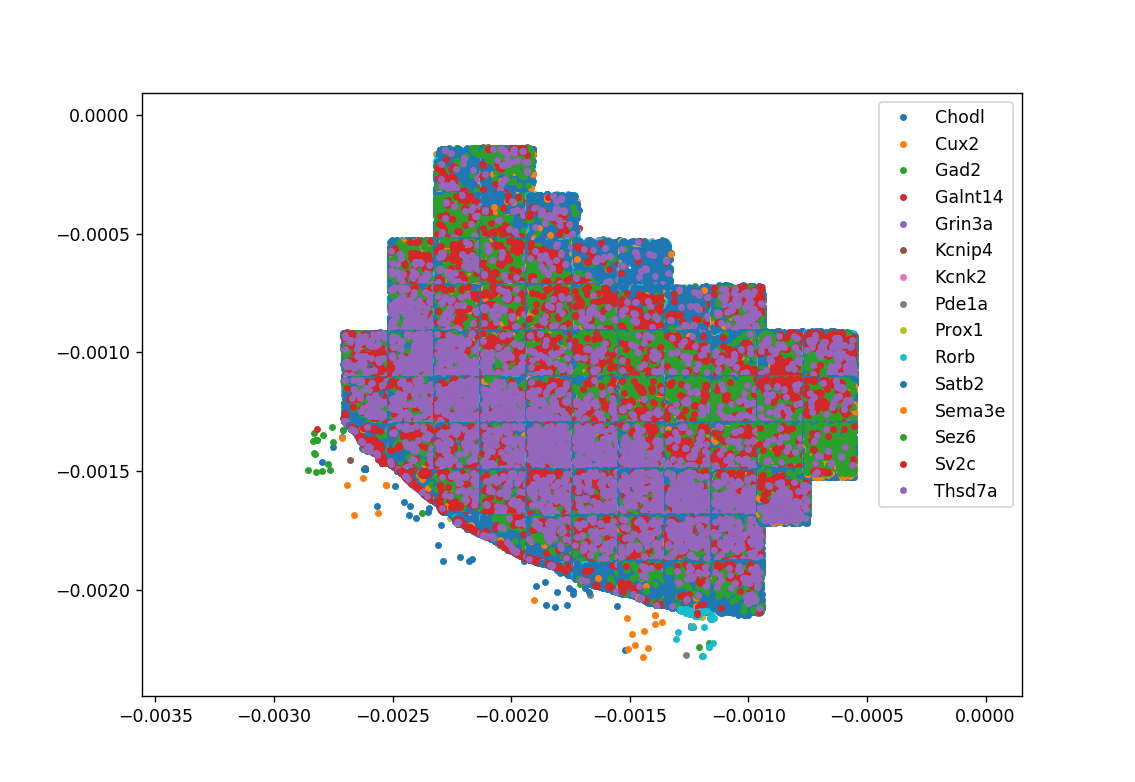

(-0.0029709952999837697,
 -0.0004356609075330198,
 -0.0023892203556897585,
 -2.8091225976822892e-05)

In [115]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure()
for ii,fov in enumerate(decoded_intensities):
    targetlist_index=0
    for targetname,targetdata in list(fov["decoded"].groupby("target")):
        if ii==10:
            plt.plot(targetdata["xc"], targetdata["yc"],'.', label = targetname, color = colors[targetlist_index])
        else:
            plt.plot(targetdata["xc"], targetdata["yc"],'.', label = '_nolegend_', color = colors[targetlist_index])
            
        targetlist_index = np.mod(targetlist_index + 1,len(colors))


#plt.plot(it002[it002["target"]=="Gad2"]["xc"], it002[it002["target"]=="Gad2"]["yc"],'o')
plt.legend()

plt.axis('equal')
'Satb2', 'Cux2', 'Gad2', 'Foxp2', 'Prox1', 'Rorb', 'Lhx6', 'Chodl',
       'Sv2c', 'Parm1', 'Gad2', 'Grin3a', 'Fezf2', 'Thsd7a', 'Pde1a', 'Mpped1',
       'Sema3e', 'Galnt14', 'Alcam', 'Sez6', 'Kcnk2', 'Pvalb', 'Kcnip4',
       'Gad2', 'Satb2', 'Kcnip4', 'Gad2']

In [8]:
# this is supposed to be cool, but doesn't work here. should probably be tested first with a smaller dataset.
starfish.display.stack(experiment["fov_002"]["primary"], it002)
#

100%|██████████| 918/918 [02:00<00:00,  8.05it/s]


# Cell below created the experiment used in this notebook.

actual data is 77 FOVs, the version saved here only uses 3

In [ ]:



output_dir = "/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/Allen_SpaceTx_Mouse_with_DAPI/"
input_dir = "/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_AIBS-Boyden_Broad-Inhibitory_102318/"

write_experiment_json(
        output_dir,
        77,
        ImageFormat.TIFF,
        primary_image_dimensions={
            Axes.ROUND: 9,
            Axes.CH: 3,
            Axes.ZPLANE: 34,
        },
        aux_name_to_dimensions={
            'nuclei': {
                Axes.ROUND: 9,
                Axes.CH: 1,
                Axes.ZPLANE: 34,
            },

        },
        primary_tile_fetcher=flad.AllenPrimaryTileFetcher(input_dir),
        aux_tile_fetcher  = {"nuclei": flad.AllenPrimaryTileFetcher(input_dir, get_DAPI_only = True)},
        default_shape=SHAPE
    )


['/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_AIBS-Boyden_Broad-Inhibitory_102318/mFISH__001', '/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_AIBS-Boyden_Broad-Inhibitory_102318/mFISH__002', '/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_AIBS-Boyden_Broad-Inhibitory_102318/mFISH__003', '/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_AIBS-Boyden_Broad-Inhibitory_102318/mFISH__004', '/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_AIBS-Boyden_Broad-Inhibitory_102318/mFISH__006', '/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_AIBS-Boyden_Broad-Inhibitory_102318/mFISH__007', '/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_AIBS-Boyden_Broad-Inhibitory_102318/mFISH__008', '/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_AIBS-Boyden_Broad-Inhibitory_102318/mFISH__009', '/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_AIBS-Boyden_Broad-Inhibitory_102318/mFIS

/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72df8af780> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72faf57ca8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72faf579e8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72faf578e0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72faf57a40> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a2afc0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a2aeb8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a2a5c8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a2aa98> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a2abf8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a3eaf0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a3ee08> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a3ef10> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79c7048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79c71a8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79c74c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79c76d0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a3edb0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a3ea98> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a3e410> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a3e200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79da308> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79da200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79da570> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79da678> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79e6620> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79e6678> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79e6990> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a2ae08> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79c7150> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79e6830> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79e6150> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79eea40> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79ee888> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79ee678> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f5a98> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f5678> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f5048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f5eb8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f5fc0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d798b468> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d798b728> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d798b830> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f5410> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f5620> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79811a8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7981a40> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79997d8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7999678> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79992b0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79a58e0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79a5570> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79a5410> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79a5200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79a5308> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79aea40> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79ae8e0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79ae308> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79816d0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d798bbf8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79be620> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79be728> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79be888> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79be990> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7999780> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79be7d8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79be4c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7949d00> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7949ba0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7949938> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7954570> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d795f048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d795f150> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d795f2b0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d795f3b8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a2adb0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a2a518> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79a5c50> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79a57d8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7a2a9e8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79998e0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7999db0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79a5d58> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7968830> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7968048> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79683b8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79a5fc0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79a5258> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79c98e0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79c9780> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79d3d00> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79d3b48> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79d3938> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79d37d8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79d3360> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f1518> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f1620> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f1728> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f1830> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79d3048> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79e5e60> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f15c8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f1258> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f1e08> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7941830> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7970200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7970360> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7970468> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7963f68> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79632b0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7970f10> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79705c8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79703b8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7970048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79707d8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7978620> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7970eb8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79702b0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79f1d58> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79410a0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79e5780> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7978938> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7978a98> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d797d780> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d797d360> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7978e60> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d797d728> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d797dc50> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7906ba0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7906888> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7926570> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7926678> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7926780> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7926990> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7906938> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7931468> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79780f8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d797d308> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7906d58> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7910f68> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7931c50> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79c9d00> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7968ba0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7931d00> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7931570> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d794df68> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d796f048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d796f150> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d796f2b0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d796f3b8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79798e0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d794d3b8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d794d7d8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79318e0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d796f410> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78ff4c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78ff0a0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78ffb48> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78ffca8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78ffdb0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78ff620> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78ffa98> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7979d00> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7979048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d794daf0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7929bf8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7929d00> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78c2048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78c2150> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7929f68> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78c70f8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78c7200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78c7308> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78c3f68> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78c3c50> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78d3150> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78d3308> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78d3410> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78c7f68> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78c7e60> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78c7728> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78c3830> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78de468> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78de360> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78de150> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78eb150> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78eb8e0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78eb9e8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78ebaf0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78ebbf8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78eba98> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78ebc50> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78f4308> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78f41a8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78f4620> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78fe830> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78feb48> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78fec50> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78feeb8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78eb360> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7938d00> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7938e60> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7938f68> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78d30a0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7938f10> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7938410> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7938db0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78d3ba0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78cbd00> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78cbb48> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78cbd58> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78cb9e8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78cb258> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78cbf10> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78d3e60> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7880f68> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d788f0a0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d788f150> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7880f10> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7880d58> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d788f938> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7880570> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7880990> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7895360> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7895200> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d789ddb0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7880678> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d788f518> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d788fe08> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7895af0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78a5570> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78a5780> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d788f8e0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7895780> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78953b8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78a5ca8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78a5888> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78a5fc0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7895d58> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7895518> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7843678> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d789d620> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78a5150> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78b16d0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78b1a98> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7843a40> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7843d00> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d784c9e8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d784c8e0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d784c6d0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78ba4c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7880fc0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78b91a8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78b92b0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78b9410> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78444c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7844308> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78440f8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7844728> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7844830> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78b9888> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d785beb8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d785bd58> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d785bb48> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d785b0a0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d786a3b8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d786a4c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d786a6d0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d786a780> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d786a8e0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7863b48> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d786a728> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d786a360> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7873c50> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7873af0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d787d938> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d787d780> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d787d1a8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d787d3b8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d787da98> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78102b0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7808f68> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7808ca8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78084c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78086d0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7810af0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7808d58> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7808468> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d787dc50> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d787d728> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78b97d8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78ba3b8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d787db48> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d787d258> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78260a0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d782d7d8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d782d938> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d782db48> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d787d4c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78295c8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7835258> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7835e08> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7835f10> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7835fc0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d783e0f8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d783e150> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d783e4c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d783efc0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d79360f8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d783ef68> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77ccca8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d782d990> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d782dc50> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d783e830> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7936780> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77e14c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77e15c8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77e1728> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77e17d8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77d5fc0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77e26d0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77e27d8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77e2938> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77e2bf8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d78ba5c8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77fe678> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77f1fc0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77f1200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77f1a98> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77f1ca8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7785830> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77856d0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77854c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7785308> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77851a8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7791e60> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77f1570> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77fea98> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7785990> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7785518> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7791a98> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7791780> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77914c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d779d048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d779d2b0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77aa468> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77aa570> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77aa7d8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77aa888> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77aaaf0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7785780> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7785e60> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77b80a0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77b8200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77b8308> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7741af0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7741d00> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7741db0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7741fc0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77490f8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d774c258> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d774cfc0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77520f8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7752200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7752360> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d774c6d0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7741360> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77525c8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77522b0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7752a98> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7759570> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77591a8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77599e8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7759d58> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7761888> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7770f10> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7775048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7775150> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7770f68> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7770d58> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d777ed00> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d777eba0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d777e9e8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d777e888> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d777e1a8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77100a0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7710200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7710308> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7710410> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7710518> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7715728> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7715830> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77055c8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7705d00> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d777eca8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7710e60> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77155c8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d77151a8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7715e08> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d771c888> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7727fc0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7732150> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7732258> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7732308> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7727f10> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7732ba0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7727410> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7727780> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7727ba0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d771c048> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76cf518> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76cf1a8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76cf9e8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76d3728> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76d35c8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76dab48> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76dae08> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76daf10> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76e2048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76e2150> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76e2678> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76e28e0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76e2bf8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76da0f8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76da5c8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76e2938> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76f7518> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76f73b8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76f7830> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76f7938> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76806d0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76805c8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7680360> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7680200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76802b0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d769d258> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7695fc0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7695ca8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7695048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7695360> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7680b48> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76a6360> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76a6200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76a6570> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76a6678> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76953b8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76ae678> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76ae410> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76ae200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76ae0a0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76aeb48> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76aedb0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76a67d8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76a6b48> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d769d7d8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76ba258> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76ba048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76baa98> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76bad58> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76959e8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76618e0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76619e8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7661af0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7661bf8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7661d00> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7661830> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7661150> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7661e08> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7669d58> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7669ba0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7669ca8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7669990> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7669678> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76693b8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7672f68> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d767cb48> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d767cc50> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7669a98> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7669258> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7672e60> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d767caf0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d767c1a8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d767ce60> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d767cdb0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d767c570> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7633048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76332b0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76333b8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76334c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d76335c8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75c00f8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75c0200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75c0360> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75c0468> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75c0570> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75c7308> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75c74c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75c75c8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75c76d0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75c77d8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75f20a0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75f21a8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75ecfc0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75ecca8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75ecaf0> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75f24c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75f27d8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75f29e8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75f2f68> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d757f0f8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75f2830> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7584200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7584308> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7584410> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7584518> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75b41a8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75b4990> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75b4a98> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75b4ba0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75b4ca8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75b9fc0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75410f8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7541200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75b9f68> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75b9c50> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75b47d8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7578200> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7578048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75784c0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d75785c8> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7502af0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7502bf8> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7502d00> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7502e08> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7578b48> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d74c0468> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d74c0570> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d74c0678> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d74c0780> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7538f68> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d74f7830> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d74f7938> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d74f7a40> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d74f7b48> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d74f7c50> is a low contrast image


/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d747fe60> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d747ff68> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d7486048> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d747ffc0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/brianl/anaconda3/envs/starfish/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: <_io.BytesIO object at 0x7f72d747fd00> is a low contrast image


In [147]:
# # once analyzed and saved to disk, you can reload the IntensityTable like this

# it000 = starfish.IntensityTable.load("/home/brianl/Desktop/temp/CZI_test_01/"+
#                               "fov_000"+"01_.ncdf")
# it001 = starfish.IntensityTable.load("/home/brianl/Desktop/temp/CZI_test_01/"+
#                               "fov_001"+"01_.ncdf")
# it002 = starfish.IntensityTable.load("/home/brianl/Desktop/temp/CZI_test_01/"+
#                               "fov_002"+"01_.ncdf")

# # and single FOVs

# f1=experiment["fov_001"]
# f2=experiment["fov_002"]
# f0=experiment["fov_000"]


In [152]:
%gui qt
import starfish.display

In [162]:
starfish.display.stack(experiment["fov_003"]["primary"], decoded_intensities[1]["decoded"])


 34%|███▎      | 309/918 [00:56<01:44,  5.84it/s]


 67%|██████▋   | 617/918 [01:51<00:48,  6.17it/s]


100%|██████████| 918/918 [02:45<00:00,  5.69it/s]

In [120]:
cf = plt.gcf()
    

In [121]:
cf.savefig("starfish.png")

In [158]:
experiment["fov_001"]

<starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (c: 3, z: 34, r: 9, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (c: 1, z: 34, r: 9, x: 1536, y: 1024)>

In [161]:
experiment.codebook["target"]

<xarray.Codebook 'target' (target: 27)>
array(['Satb2', 'Cux2', 'Gad2', 'Foxp2', 'Prox1', 'Rorb', 'Lhx6', 'Chodl',
       'Sv2c', 'Parm1', 'Gad2', 'Grin3a', 'Fezf2', 'Thsd7a', 'Pde1a', 'Mpped1',
       'Sema3e', 'Galnt14', 'Alcam', 'Sez6', 'Kcnk2', 'Pvalb', 'Kcnip4',
       'Gad2', 'Satb2', 'Kcnip4', 'Gad2'], dtype=object)
Coordinates:
  * target   (target) object 'Satb2' 'Cux2' 'Gad2' ... 'Satb2' 'Kcnip4' 'Gad2'